# Training of  Herkules Weight Forecast Project for Import parcels(INT)

In [1]:
# 1. Import packages for data analysis
import pandas as pd
import numpy as np          
import matplotlib.pyplot as plt
import os
import zipfile
import openpyxl
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from  IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# 2. Import packages for time analysis
import time
import datetime as dt
from datetime import date
from datetime import timedelta
from datetime import datetime

# 3 Open Teradata Connection. Import packages for time analysis
from pnp_connectors.connection_config_holders import TeradataConfig
from pnp_connectors.quick_create import QuickCreate

# 3.1 create config
td_config = TeradataConfig(
 host="TDP-N0201.deutschepost.dpwn.com",
 secret_user_name=os.getenv("TERADATA_USER"),
 secret_password=os.getenv("TERADATA_PASSWORD")
)

# 3.2 create connection
td_connection = QuickCreate.create_teradata_connection(td_config=td_config)

# 4. Funktion zum Löschen nicht mehr benötigter Tabellen
def drop_table(tab_name):
    try:
        td_connection.execute_sql(f'''DROP TABLE {tab_name}''')
        print(f'''{tab_name} dropped.''')
    except: 
        print(f'''{tab_name} nicht vorhanden''')
         
def create_table(Tabelle, SQL, Index):
    # Falls notwendig löschen der neuen Tabelle, dann Tabelle ohne Daten erstellen und Daten einfügen:
    drop_table(Tabelle)
    td_connection.execute_sql(f'''CREATE MULTISET TABLE {Tabelle} AS ( {SQL}) WITH NO DATA PRIMARY INDEX({Index})''')
    print(Tabelle + ' initialised with PI ' + Index)
    td_connection.execute_sql(f'''INSERT INTO  {Tabelle} {SQL}''')
    test = td_connection.select(f'''select count(1) as anzahl_ds from {Tabelle}''')
    anzahl = str(test['anzahl_ds'].values[0])
    print(f'''{anzahl} DS injected into table {Tabelle}.''')
    print(' ')
    
# 5. test connection
result = td_connection.select("select * FROM DB_NEXTT_DWH.vw_event_zust where sendungs_code = '340434197332847059'")
result.head()

,SENDUNGS_CODE,MODALITAET,EREIGNIS_DATUM,EREIGNIS_ZEITSTEMPEL,LEIT_PLZ,LEIT_STR,LEIT_HNR,LEIT_PRODUKT_CODE,EPOS_KASSEN_NR,FILIAL_DIREKTIONS_NR,FILIAL_NIEDERLASSUNGS_NR,FILIAL_NR,FILIAL_STRASSEN_NAME,FILIAL_PLZ,FILIAL_ORTS_NAME,EPOS_VORGANGSART,EREIGNISTYP,ZIEL_PZ,ZIEL_ZUSTELLBASIS,ZIEL_ZUSTELLBEZIRK,ZIEL_ZUSTELL_ABSCHNITT,SENDUNGSART,EREIGNIS_JAHR,LISTENTYP,LISTEN_NR,LISTEN_POSITION,BENACHRICHTIGUNGS_IDC,NACHNAHME_BETRAG,NACHNAHME_ZAHLUNGSART,ENTGELT_BETRAG,ENTGELT_ZAHLUNGSART,ZOLLEINFUHR_BETRAG,ZAHLSCHEINENTGELT_KENNUNG,WAEHRUNG,STORNOKENNZEICHNUNG,SAMMELBEHAELTER_NR,FOLGETAG,EMPFAENGER,BETRIEBS_NR,ZUSTELLER_NAME,EMPFANGSKENNZEICHNUNG,EMPFAENGER_NAME,AUSWEIS_NR,AUSWEISBEHOERDEN_NAME,AUSWEISKENNZEICHNUNG,AUSWEISGUELTIGKEIT,ERSATZEMPFAENGER_NAME,HSC_ERROR_CODE,PROCESS_ID,DATA_SOURCE_ID,LINE_NO,LOAD_TIMESTAMP,DATA_SOURCE_TYPE_ID,APPL_01_FLAG,APPL_02_FLAG,APPL_03_FLAG,APPL_04_FLAG,APPL_05_FLAG,APPL_06_FLAG,APPL_07_FLAG,APPL_08_FLAG,LP_DATA_SOURCE,HANDSCANNER_VERSION,ZAHLUNGSART,RUECKFUEHRUNGSENTGELT_BETRAG,UNTERZEICHNER_NAME,MANUELLE_EINGABE,SENDUNGSART_2,PRODUKT_TYP,ZUORDNUNGS_ID,TAS_AUFTRAGS_NR,AUFTRAGSKENNZIFFER,UNBAR_BETRAG,BAR_BETRAG,VERSCHLUESSELUNG,CEP_VERS,CEP_MINLESE_VERS,STATIONSKENNUNG,PST_PLZ,PST_NR,UNTERSCHRIFTSART,SST_PST_NEXTT,SENDUNGS_CODE_TYP,ANZ_N_NACHW_PFL_SDG,LFD_NR_TAS_M_SCANN,MEZ_KUNDENNUMMER,PST_KUNDEN_NR,DROPPOINT_NR,DIENST_KZ,JOURNALSATZNR,AUSWEIS_SONDERFALL,NACHNAHME_BETRAG2,ENTGELT_BETRAG2,BELEGPOS_ENDE,LOAD_ID,N_AUFTRAGSNUMMER,POSITIONSNUMMER,ESR_KENNZIFFER,STATIONSKENNUNG_2,LEITINFO_ALT,SHIPMENT_NR,AUSLIEFER_FLAG,ANZAHL_PS,POSITION_NO,LC_GESCANNT,SCANNER_ID,PERSONAL_NR,GEB_DATUM,ALTERSGRENZE,STP_ID,SCAN_ORT,GRUENE_KARTE,FILIAL_OZ,IDP_KORR,VERTRAGS_IDC,SESSION_ID,ZUSTELL_FLAG,TEZU_DATUM,GID,ZAHLUNGSEMPFAENGER,KONTONUMMER,BLZ,VERWENDUNGSZWECK_1,VERWENDUNGSZWECK_2,FREITEXTWERT,FREITEXT,FREITEXT_KORREKT,STAATSANGEHOERIGKEIT,STAATSANGEHOERIGKEIT_KORREKT,AUSWEISARTID,MELDEANSCHRIFT,VERTRAGSABWICKLUNG,FELDVALIDIERUNGFEHLGESCHLAGEN,AST_ID,POSTCARD_NR,EEA_FLAG,EEA_STRASSE,EEA_HNR,BETRIEBS_NR_KN,UNTERZEICHNER_NAME_KN,EVENT_ID,ARCH_ZEITRAUM,ETL1_DATA_SOURCE_ID,ETL1_LOAD_ID,ETL1_LOAD_DTM,ETL1_LINE_NO,IBAN,BIC,SERVICE_KUERZEL,EVENT_PSLZ_ID,ERZEUGUNGSORT_LAENDERCODE,LAGERN_BIS_DT,UNTERSCHRIFT_BILD_ID,UNTERSCHRIFT_BILD_INHALT,UNTERSCHRIFT_BILD_EXISTS_FLAG,AUTHENTIFIZIERUNGS_TYP,UNTERSCHRIFT_BILD_MIME_TYPE,ERZEUGUNGSORT_AGNR,ARCH_FLAG,ESR_ZUSTELL_DATUM,PAKETKASTEN_ID,POSTMAN_POSTNUMBER,POSTMAN_LOGISTIC_PROVIDER,LOGISTIK_NETZ,PPO_VERS,EINLIEFERER_VORNAME,EINLIEFERER_NAME,EINLIEFERER_STRASSE,EINLIEFERER_HNR,EINLIEFERER_PLZ,EINLIEFERER_ORT,EINLIEFERER_LAENDERCODE,EMPFAENGER_VORNAME,EMPFAENGER_STRASSE,EMPFAENGER_HNR,EMPFAENGER_PLZ,EMPFAENGER_ORTSNAME,EMPFAENGER_LAENDERCODE,EVENT_ART_PAKETSHOP,NICHT_ZUSTELLUNGSGRUND,UEBERGABE_VON,UEBERGABE_ZU,EXTERNE_PAKETSHOP_ID,ISBT_PAKETSHOP_NR,PLZ_CODE_PAKETSHOP_NR,PAKETSHOP_LAENGENGRAD,PAKETSHOP_BREITENGRAD,PAKETSHOP_STRASSEN_NAME,PAKETSHOP_HAUSNUMMER,PAKETSHOP_HAUSNUMMER_ZUSATZ,PAKETSHOP_PLZ,PAKETSHOP_ORTS_NAME,PAKETSHOP_LAENDERCODE,PAKETSHOP_INTERNATIONAL_NR,PAKETSHOP_BETRIEBSMODUS,SERVICE_EMPFAENGER_NACHNAME,SERVICE_EMPFAENGER_VORNAME,PAKET_STATUS,FSHDUPLIKAT_FLAG,GUELTIG_FLAG,ODS_EVENT_ID,PRIMARY_CRITERIA,SECONDARY_CRITERIA,CORR_TO_BE_ARCHIVED_ORIGINATOR,CORR_SCRIPT_ID,CORR_INSTRUCTION_ID,CORR_PROTOCOL_VERSION,CORR_ERROR_CODE,CORR_CHECK_CODE,CORR_ORIG_EVENT_ID,CREATION_LOC_ADDRESS_COUNTRY,PROD_LOCATION_CODE_AGNR,FORMAT_ADJUST_SYNTHETIC_EVENT,FORMAT_ADJUST_CORRECTION_TS,FORMAT_ADJUST_REVISER,FORMAT_ADJUST_COMMENT,FORMAT_ADJUST_POST_PROC_ADJUST,FORMAT_ADJUST_ORIG_EVENT_ID,FORMAT_ADJUST_ORIG_EVT_PRED_ID,EVT_MSG_HDR_DS_DSTID,PSLZ_ID,SHIP_ID,VALID_ROUTING_CODE_TYPE_1,VALID_RC_1_COUNTRY_CODE,VALID_RC_1_POSTAL_CODE,VALID_RC_1_STREET_CODE,VALID_RC_1_HOUSE_NUMBER,VALID_RC_1_PRODUCT_CODE_BASIS,VALID_RC1_PRODUCT_CODE_FEATURE,VALID_ROUTING_CODE_TYPE_2,VALID_RC_2_COUNTRY_CODE,VALID_RC_2_POSTAL_CODE,VALID_RC_2_STREET_CODE,VALID_RC_2_HOUSE_NUMBER,VALID_RC_2_PRODUCT_CODE_BASIS,VALID_RC2_PRODUCT_

# Data Collection

In [2]:
#get the data from different tables for 12 months 
x = 1

now = date.today() 
jahr_akt = now.year
monat_akt = now.month 

if monat_akt == 1:
    monat = 11
    jahr = jahr_akt - 1
elif monat_akt == 2:
    monat = 12
    jahr = jahr_akt - 1
else:
    monat = monat_akt - 2
    jahr = jahr_akt

while x <= 10:

    if monat == 12:
        monat2 = 1
        jahr2 = jahr + 1
    else:
        monat2 = monat + 1
        jahr2 = jahr
        
    if x ==1:
        monat_ende = monat2
        jahr_ende = jahr2
    
    monat_anfang = monat
    jahr_anfang = jahr

    datum1 = date(year = jahr, month = monat, day = 1)  # Erster Tag der Analyse
    datum2 = date(year = jahr2, month = monat2, day = 1) # Erster Tag, der NICHT in der Analyse inkludiert ist
    datum1_PAN = datum1 + timedelta(days=-10)
    datum2_PAN = datum2 + timedelta(days=+10)

    print(datum1, datum2, datum1_PAN, datum2_PAN)
    
    #Identify import parcels:

    # •	UPU S10 Sendung_code (Type 6) 
    # o	starts with C, do not ends with DE
    # o	starts with EP, ends with CH or IT
    # o	starts with EE or EK, ends with GB
    # o	starts with EH, ends with GB (these are usually shipments from Germany that were undeliverable in GB, but for which the original IDC is unfortunately no longer recognizable)
    # o	starts with EG-EO or EQ-ER, ends with IE
    # identify import parcels with product code= 74 i.e., international re-toures
    Tabelle = 'DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_ohne_PAN_0a'
    SQL = f'''
        select distinct sendungs_code from
            (
            select       sendungs_code
            from DB_NEXTT.PZA_event
            where   ereignis_datum >= cast('{datum1}' as date)  and ereignis_datum < cast('{datum2}' as date)
                    and LEIT_PRODUKT_CODE = 74
                    and         ((substr(sendungs_code,1,1) = 'C' and right(sendungs_code,2) <> 'DE')  or
                                 (substr(sendungs_code,1,2) = 'EP' and right(sendungs_code,2) ='CH') or
                                 (substr(sendungs_code,1,2) = 'EP' and right(sendungs_code,2) ='IT') or
                                 (substr(sendungs_code,1,2) = 'EE' and right(sendungs_code,2) ='GB') or
                                 (substr(sendungs_code,1,2) = 'EK' and right(sendungs_code,2) ='GB') or
                                 (substr(sendungs_code,1,2) = 'EH' and right(sendungs_code,2) ='GB') or
                                 (substr(sendungs_code,1,5) = 'EG-EO' and right(sendungs_code,2) ='IE') or
                                 (substr(sendungs_code,1,5) = 'EQ-ER' and right(sendungs_code,2) ='IE')) 
                                 
            union all

            select       sendungs_code
            from DB_NEXTT.PZE_event
            where      ereignis_datum >= cast('{datum1}' as date)  and ereignis_datum < cast('{datum2}' as date)
                    and LEIT_PRODUKT_CODE = 74
                    and         ((substr(sendungs_code,1,1) = 'C' and right(sendungs_code,2) <> 'DE')  or
                                 (substr(sendungs_code,1,2) = 'EP' and right(sendungs_code,2) ='CH') or
                                 (substr(sendungs_code,1,2) = 'EP' and right(sendungs_code,2) ='IT') or
                                 (substr(sendungs_code,1,2) = 'EE' and right(sendungs_code,2) ='GB') or
                                 (substr(sendungs_code,1,2) = 'EK' and right(sendungs_code,2) ='GB') or
                                 (substr(sendungs_code,1,2) = 'EH' and right(sendungs_code,2) ='GB') or
                                 (substr(sendungs_code,1,5) = 'EG-EO' and right(sendungs_code,2) ='IE') or
                                 (substr(sendungs_code,1,5) = 'EQ-ER' and right(sendungs_code,2) ='IE')) 
            )    as tmp 
            
        '''
    Index = 'sendungs_code'
    create_table(Tabelle, SQL, Index)
    

   # import parcels without retoure parcels from private customers

    Tabelle = 'DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_0'
    SQL = f'''
        select distinct sendungs_code from
            (
            select       sendungs_code
            from DB_NEXTT.PZA_event
            where      ereignis_datum >= cast('{datum1}' as date)  and ereignis_datum < cast('{datum2}' as date)
                    and sendungs_code not in (select sendungs_code from DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_ohne_PAN_0a)
                    and         ((substr(sendungs_code,1,1) = 'C' and right(sendungs_code,2) <> 'DE')  or
                                 (substr(sendungs_code,1,2) = 'EP' and right(sendungs_code,2) ='CH') or
                                 (substr(sendungs_code,1,2) = 'EP' and right(sendungs_code,2) ='IT') or
                                 (substr(sendungs_code,1,2) = 'EE' and right(sendungs_code,2) ='GB') or
                                 (substr(sendungs_code,1,2) = 'EK' and right(sendungs_code,2) ='GB') or
                                 (substr(sendungs_code,1,2) = 'EH' and right(sendungs_code,2) ='GB') or
                                 (substr(sendungs_code,1,5) = 'EG-EO' and right(sendungs_code,2) ='IE') or
                                 (substr(sendungs_code,1,5) = 'EQ-ER' and right(sendungs_code,2) ='IE'))
                                 
            union all

            select       sendungs_code
            from DB_NEXTT.PZE_event
            where      ereignis_datum >= cast('{datum1}' as date)  and ereignis_datum < cast('{datum2}' as date)
                    and sendungs_code not in (select sendungs_code from DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_ohne_PAN_0a)
                    and         ((substr(sendungs_code,1,1) = 'C' and right(sendungs_code,2) <> 'DE')  or
                                 (substr(sendungs_code,1,2) = 'EP' and right(sendungs_code,2) ='CH') or
                                 (substr(sendungs_code,1,2) = 'EP' and right(sendungs_code,2) ='IT') or
                                 (substr(sendungs_code,1,2) = 'EE' and right(sendungs_code,2) ='GB') or
                                 (substr(sendungs_code,1,2) = 'EK' and right(sendungs_code,2) ='GB') or
                                 (substr(sendungs_code,1,2) = 'EH' and right(sendungs_code,2) ='GB') or
                                 (substr(sendungs_code,1,5) = 'EG-EO' and right(sendungs_code,2) ='IE') or
                                 (substr(sendungs_code,1,5) = 'EQ-ER' and right(sendungs_code,2) ='IE'))
            )    as tmp                 
        '''
    Index = 'sendungs_code'
    create_table(Tabelle, SQL, Index)

    
    #get the  weight for the import parcels where we do not have the real weighing scale as pan weight from PZA_table
    #(we are taking this because we do not have pan data for import parcels from private customers)
    
    
    Tabelle = 'DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_1'
    SQL = f'''

            select 	sendungs_code, ereignis_datum, gewicht as gewicht_pan
            from DB_NEXTT.PZA_event
            where 	ereignis_datum >= cast('{datum1}' as date)  and ereignis_datum < cast('{datum2}' as date)
                            and Gewicht_Quelle not in ('W', 'Y')
                            and gewicht > 0 
                            and sendungs_code in (Select sendungs_code from DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_0)
            Qualify (ROW_NUMBER() OVER(PARTITION BY sendungs_code ORDER BY ereignis_datum ASC)) = 1
        

        '''
    Index = 'sendungs_code'
    create_table(Tabelle, SQL, Index)
    
    #get the data from DB_NEXTT.PZA_event, DB_NEXTT.PZE_event, DB_NEXTT_Hist.PZA_event, DB_NEXTT_Hist.PZE_event into single table 
    #also last two digits of sendungs code is country from  where the parcel is sent
    Tabelle = 'DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_2'
    SQL = f'''
            Select
                sendungs_code,
                right(sendungs_code,2) as country_code,
                ERFASSUNGSORT as PZ_NR,
                min(LEIT_PRODUKT_CODE) as product_code,
                avg(gewicht) as gewicht_real,
                min(gewicht_quelle) as gewicht_quelle,
                avg(volumen_pals) as Volumen,
                avg(laenge) as laenge,
                avg(breite) as breite,
                avg(hoehe) as hoehe,
                count(sendungs_code) as anzahl_messungen,
                max(ereignis_zeitstempel) as pza_timestamp, 
                max(ereignis_datum) as pza_datum,
                min(ereignis_typ) as ereignis_typ, 
                max(zeit) as pza_uhrzeit,
                max(ZIELKENNUNG_AGNR) as ziel_pze_agnr,
                min(WEIGHT_LEGAL_CODE) as Status_PMES_1,
                max(WEIGHT_LEGAL_CODE) as Status_PMES_2
            from (
                    Select 
                        sendungs_code, ERFASSUNGSORT, LEIT_PRODUKT_CODE, gewicht, gewicht_quelle, volumen_pals, laenge, breite, hoehe,
                        ereignis_zeitstempel, ereignis_datum, ereignis_typ, 
                        EXTRACT( HOUR FROM ereignis_zeitstempel)*60+EXTRACT(MINUTE FROM ereignis_zeitstempel) as zeit,
                        cast(ziel_pz as int) as ziel_pz, ZIELKENNUNG_AGNR, WEIGHT_LEGAL_CODE

                    from DB_NEXTT.PZA_event
                    where 	ereignis_datum >= cast('{datum1}' as date)  and ereignis_datum < cast('{datum2}' as date)
                            and LEIT_PRODUKT_CODE not in (72, 73)
                            and Gewicht_Quelle in ('W', 'Y')
                            and gewicht > 0  
                            and sendungs_code in (Select sendungs_code from DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_0)
                            
                    union all

            
                    Select 
                        sendungs_code, ERFASSUNGSORT, LEIT_PRODUKT_CODE, gewicht, gewicht_quelle, volumen_pals, laenge, breite, hoehe,
                        ereignis_zeitstempel, ereignis_datum, ereignis_typ, 
                        EXTRACT( HOUR FROM ereignis_zeitstempel)*60+EXTRACT(MINUTE FROM ereignis_zeitstempel) as zeit,
                        cast(ziel_pz as int) as ziel_pz, ZIELKENNUNG_AGNR, WEIGHT_LEGAL_CODE
                    from DB_NEXTT.PZE_event
                    where 	ereignis_datum >= cast('{datum1}' as date)  and ereignis_datum < cast('{datum2}' as date)
                            and LEIT_PRODUKT_CODE not in (72, 73)
                            and Gewicht_Quelle in ('W', 'Y')
                            and gewicht > 0  
                            and sendungs_code in (Select sendungs_code from DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_0)

                 
        
                    union all
        
                    Select 
                        sendungs_code, ERFASSUNGSORT, LEIT_PRODUKT_CODE, gewicht, gewicht_quelle, volumen_pals, laenge, breite, hoehe,
                        ereignis_zeitstempel, ereignis_datum, ereignis_typ, 
                        EXTRACT( HOUR FROM ereignis_zeitstempel)*60+EXTRACT(MINUTE FROM ereignis_zeitstempel) as zeit,
                        cast(ziel_pz as int) as ziel_pz, ZIELKENNUNG_AGNR, WEIGHT_LEGAL_CODE
                    from DB_NEXTT_Hist.PZA_event
                    where 	ereignis_datum >= cast('{datum1}' as date)  and ereignis_datum < cast('{datum2}' as date)
                            and LEIT_PRODUKT_CODE not in (72, 73)
                            and Gewicht_Quelle in ('W', 'Y')
                            and gewicht > 0  
                            and sendungs_code in (Select sendungs_code from DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_0)
                 

                    union all

            
                    Select 
                        sendungs_code, ERFASSUNGSORT, LEIT_PRODUKT_CODE, gewicht, gewicht_quelle, volumen_pals, laenge, breite, hoehe,
                        ereignis_zeitstempel, ereignis_datum, ereignis_typ, 
                        EXTRACT( HOUR FROM ereignis_zeitstempel)*60+EXTRACT(MINUTE FROM ereignis_zeitstempel) as zeit,
                        cast(ziel_pz as int) as ziel_pz, ZIELKENNUNG_AGNR, WEIGHT_LEGAL_CODE
                    
                    from DB_NEXTT_Hist.PZE_event
                    where 	ereignis_datum >= cast('{datum1}' as date)  and ereignis_datum < cast('{datum2}' as date)
                            and LEIT_PRODUKT_CODE not in (72, 73)
                            and Gewicht_Quelle in ('W', 'Y')
                            and gewicht > 0  
                            and sendungs_code in (Select sendungs_code from DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_0)

            ) as tmp
            group by sendungs_code, ERFASSUNGSORT
        
        '''
    Index = 'sendungs_code'
    create_table(Tabelle, SQL, Index)
 

    
    #Collecting the shape of the parcel data from VW_PEM_ADD table for the parcels which are in Herkules_Train_int_1 
    
    Tabelle = 'DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_3'
    SQL = f'''
            Select 		piece_code as sendungs_code,
                        special_type_61 as BAP_feature,
                        tb_load_dtm,
                        case 
                        when BAP_feature.SHAPE is NOT NULL then BAP_feature.SHAPE
                        else 'None'
                        end as parcel_shape
                    
                        
            from 		DB_NEXTT_SHIP.VW_PEM_ADD 
            
    
            where 		tb_load_dtm >= cast('{datum1}' as date)  and tb_load_dtm < cast('{datum2}' as date)
                        and sendungs_code in (select sendungs_code from DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_0 )
                        and parcel_shape is not null
            Qualify (ROW_NUMBER() OVER(PARTITION BY sendungs_code ORDER BY tb_load_dtm ASC)) = 1
            

    '''
    Index = 'sendungs_code'
    create_table(Tabelle, SQL, Index)
    
    #Joining all the three tables above and also country data from DB_NEXTT_DWH.vw_pan_partner_recipient table 
    #only selecting country_code where the count of import parcels are greater than 400, remaining as 'XX'
    Tabelle = 'DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_4' 
    SQL = f'''

            select distinct 	PZ.sendungs_code as sendungs_code,PZ.PZ_NR, pz.Gewicht_REAL, pz.Gewicht_Quelle,pz.product_code,
                    pz.Volumen, pz.laenge, pz.breite, pz.hoehe,pz.anzahl_messungen,pz.pza_datum,pz.ziel_pze_agnr,pz.Status_PMES_1,pz.Status_PMES_2,
                    PAN.ereignis_datum,PAN.Gewicht_PAN,
                    case 
                    when PZ.country_code in ('AT','BE','DK', 'FI', 'FR', 'NL', 'SE', 'LU', 'PL', 'CZ', 'ES', 'IT', 'SK',
                    'SI', 'HU', 'EE', 'LV', 'LT', 'GB', 'CH', 'IE', 'BG', 
                    'RO', 'CY', 'HR', 'PT', 'GR', 'MT', 'NO', 'US', 'CN', 
                    'MC', 'LI', 'CA', 'JP', 'AU', 'KR', 'UA',  'TW', 
                    'RU', 'TR',  'SM', 'KP', 'BR',  'VA', 'IS', 
                    'AD', 'RS',   'BY',  'NZ',  'KZ',
                    'IN', 'TH') then PZ.country_code
                    else 'XX'
                    end as country_code,
                    case 
                    when BAP.parcel_shape = 'bag' then 'bag' 
                    when BAP.parcel_shape = 'cuboid' then 'cuboid' 
                    when BAP.parcel_shape = 'envelope' then 'envelope'
                    else 'None'
                    end as parcel_shape
            from DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_2 as PZ
            left join DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_1 as PAN
            on 	PZ.sendungs_code = PAN.sendungs_code
            left join DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_3 as BAP
            on PZ.sendungs_code = BAP.sendungs_code
            

        '''
    Index = 'sendungs_code'
    create_table(Tabelle, SQL, Index)
    
    drop_table('DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_1')
    drop_table('DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_2')
    drop_table('DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_3')
    
    #create new target features and create volumen_grp feature
    Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_' + str(x)
    SQL = f'''

    select  A.*, 
                case
                    when Gewicht_Real < 20 then  0
                    when Gewicht_Real >= 20  then 1
                    else 0
               end as Flag_Gewicht_20,
               case
                    when Gewicht_Real < 10 then  0
                    when Gewicht_Real >= 10  and  Gewicht_Real < 20 then 1
                else 0
               
               end as Flag_Gewicht_10,

               case 
                    when volumen < 20 then 'V20'
                    when volumen < 30 then 'V30'
                    when volumen < 40 then 'V40'
                    when volumen < 50 then 'V50'
                    when volumen < 70 then 'V70'
                    when volumen < 90 then 'V90'
                    when volumen >= 90 then 'V99'
                    else '?'
                end as volumen_grp


        from DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_4 as A    
                    
        '''
    Index = 'sendungs_code'
    create_table(Tabelle, SQL, Index)    
    drop_table('DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_4')
      
    
    x = x +1
    
    if monat == 1:
        monat = 12
        jahr = jahr - 1
    else:
        monat = monat - 1
        jahr = jahr
        
        


2024-07-01 2024-08-01 2024-06-21 2024-08-11
DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_ohne_PAN_0a dropped.
DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_ohne_PAN_0a initialised with PI sendungs_code
13332 DS injected into table DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_ohne_PAN_0a.
 
DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_0 dropped.
DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_0 initialised with PI sendungs_code
332875 DS injected into table DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_0.
 
DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_1 nicht vorhanden
DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_1 initialised with PI sendungs_code
52667 DS injected into table DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_1.
 
DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_2 nicht vorhanden
DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_2 initialised with PI sendungs_code
72126 DS injected into table DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_2.
 
DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_3 nicht vorhanden
DBX_DWH_SBX_GB23_PRD.Herkules_Train_int_3 initial

In [4]:
# Select 12 months data always
Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_TMP1' 
SQL = f'''       
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_1 as PAN
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_2 as PAN
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_3 as PAN
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_4 as PAN
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_5 as PAN
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_6 as PAN
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_7 as PAN
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_8 as PAN
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_9 as PAN
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_10 as PAN
        /*UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_11 as PAN
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_12 as PAN*/
    '''
Index = 'sendungs_code'
create_table(Tabelle, SQL, Index)

print()
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_1"))
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_2"))
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_3"))
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_4"))
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_5"))
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_6"))
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_7"))
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_8"))
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_9"))
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_10"))
#display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_11"))
#display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_12"))
#2561894

DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_TMP1 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_TMP1 initialised with PI sendungs_code
973107 DS injected into table DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_TMP1.
 



,Count(1)
0,72126


,Count(1)
0,75993


,Count(1)
0,75055


,Count(1)
0,75892


,Count(1)
0,83929


,Count(1)
0,82756


,Count(1)
0,104798


,Count(1)
0,187874


,Count(1)
0,138204


,Count(1)
0,76480


In [21]:
#display(td_connection.select("select * from DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_TMP1 where parcel_shape ='None'"))
#display(td_connection.select("select count(1) as anzahl,parcel_shape from DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_TMP1 group by 2 "))
display(td_connection.select("select count(1) as anzahl,Flag_Gewicht_20 from DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_TMP1 group by 2 order by 2 "))
#display(td_connection.select("select count(1) as anzahl,volumen_grp from DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_TMP1 group by 2 order by 2 "))
#display(td_connection.select("select count(1) as anzahl, country_code from DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_TMP1 group by 2 order by 1 DESC "))


,anzahl,Flag_Gewicht_20
0,967374,0
1,5733,1


In [5]:
# drop the tables
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_1')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_2')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_3')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_4')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_5')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_6')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_7')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_8')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_9')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_10')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_11')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_12')

DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_1 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_2 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_3 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_4 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_5 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_6 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_7 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_8 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_9 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_10 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_11 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_Basisdaten_int_12 dropped.


# History data for the import parcels with weighing scale

In [23]:
#Consider the data from parcel centres with weighing scale to create new feautures for history table
Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_stammdaten_Herkules_int_GM' 
SQL = f'''

   SELECT 	country_code,
            case when parcel_shape is not null then parcel_shape      else 0       end as parcel_shape,
			volumen_grp,
			count(sendungs_code) as Anzahl_GM,
            case when count(distinct EREIGNIS_DATUM) is null or count(distinct EREIGNIS_DATUM) = 0 then 1 else count(distinct EREIGNIS_DATUM) end as anzahl_days,
			round(Anzahl_GM / anzahl_days) as D_Anzahl_GM,
			round(avg(hoehe)) as D_Hoehe_GM,
            min(hoehe) as D_hoehe_min_GM,
            max(hoehe) as D_hoehe_max_GM,
			round(avg(laenge)) as D_Laenge_GM,
            min(laenge) as D_laenge_min_GM,
            max(laenge) as D_laenge_max_GM,
			round(avg(breite)) as D_Breite_GM,
            min(breite) as D_breite_min_GM,
            max(breite) as D_breite_max_GM,
			greatest(1,round(avg(gewicht_real))) as D_Gewicht_real_GM, 
            min(gewicht_real) as D_Gewicht_real_min_GM,
            max(gewicht_real) as D_Gewicht_real_max_GM,
			greatest(1,round(avg(gewicht_pan))) as D_Gewicht_pan_GM, 
            min(gewicht_pan) as D_gewicht_pan_min_GM,
            max(gewicht_pan) as D_gewicht_pan_max_GM,
			greatest(1,round(avg(volumen))) as D_Volumen_GM,
            min(Volumen) as D_Volumen_min_GM,
            max(Volumen) as D_Volumen_max_GM,
			round(D_Gewicht_real_GM / D_Volumen_GM*100) as D_Volumengewicht_real_GM,
			round(D_Gewicht_pan_GM / D_Volumen_GM*100) as D_Volumengewicht_pan_GM,
            greatest(4,least(20,round((D_Laenge_GM + D_Breite_GM + D_Hoehe_GM)/100))) as D_LBH_Summe_GM,
            round(D_LBH_Summe_GM / D_Gewicht_real_GM) as D_Volumengewicht_real2_GM, 
			round(D_LBH_Summe_GM / D_Gewicht_pan_GM) as D_Volumengewicht_pan2_GM,
            greatest(-20,least(20,round(D_Gewicht_real_GM - D_Gewicht_pan_GM))) as D_Gewichtsabweichung_GM,
            sum(Flag_Gewicht_20) as Anzahl_GU_20, 
            sum(Flag_Gewicht_10) as Anzahl_GU_10,
            ((Anzahl_GU_20 * 1.00) / (Anzahl_GM * 1.00)) * 100 as D_Anteil_GU_20,
            ((Anzahl_GU_10 * 1.00) / (Anzahl_GM * 1.00)) * 100 as D_Anteil_GU_10,
            (D_laenge_max_GM - D_laenge_min_GM) as D_laenge_diff_GM,
            (D_breite_max_GM - D_breite_min_GM) as D_breite_diff_GM,
            (D_hoehe_max_GM - D_hoehe_min_GM) as D_hoehe_diff_GM,
            (D_Volumen_max_GM - D_Volumen_min_GM) as D_Volumen_diff_GM,
            (D_gewicht_pan_max_GM - D_gewicht_pan_min_GM) as D_gewicht_pan_diff_GM,
            (D_Gewicht_real_max_GM - D_Gewicht_real_min_GM) as D_gewicht_real_diff_GM,
            (D_Volumengewicht_real_GM - D_Volumengewicht_pan_GM) as D_Volumengewicht_diff_GM      
            
   FROM DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_TMP1
   group by country_code,volumen_grp,parcel_shape
    '''
Index = 'country_code,volumen_grp,parcel_shape'
create_table(Tabelle, SQL, Index)

display(td_connection.select("select parcel_shape from DBX_DWH_SBX_GB23_PRD.GS_stammdaten_Herkules_int_GM group by 1"))
display(td_connection.select("select volumen_grp from DBX_DWH_SBX_GB23_PRD.GS_stammdaten_Herkules_int_GM group by 1"))
display(td_connection.select("select country_code from DBX_DWH_SBX_GB23_PRD.GS_stammdaten_Herkules_int_GM group by 1"))

DBX_DWH_SBX_GB23_PRD.GS_stammdaten_Herkules_int_GM dropped.
DBX_DWH_SBX_GB23_PRD.GS_stammdaten_Herkules_int_GM initialised with PI country_code,volumen_grp,parcel_shape
939 DS injected into table DBX_DWH_SBX_GB23_PRD.GS_stammdaten_Herkules_int_GM.
 


,parcel_shape
0,None
1,bag
2,cuboid
3,envelope


,volumen_grp
0,V70
1,V40
2,V50
3,V99
4,V20
5,V30
6,V90


,country_code
0,MT
1,PL
2,XX
3,CA
4,GR
5,SK
6,RU
7,KZ
8,IE
9,SI


# History data for the import parcels without scales

In [24]:
#Consider the data from parcel centres without weighing scale to create new feautures for history table
x = 1

now = date.today() 
jahr_akt = now.year
monat_akt = now.month 

if monat_akt == 1:
    monat = 11
    jahr = jahr_akt - 1
elif monat_akt == 2:
    monat = 12
    jahr = jahr_akt - 1
else:
    monat = monat_akt - 2
    jahr = jahr_akt

while x <= 10:

    if monat == 12:
        monat2 = 1
        jahr2 = jahr + 1
    else:
        monat2 = monat + 1
        jahr2 = jahr
        
    if x ==1:
        monat_ende = monat2
        jahr_ende = jahr2
    
    monat_anfang = monat
    jahr_anfang = jahr

    datum1 = date(year = jahr, month = monat, day = 1)  # Erster Tag der Analyse
    datum2 = date(year = jahr2, month = monat2, day = 1) # Erster Tag, der NICHT in der Analyse inkludiert ist
    datum1_PAN = datum1 + timedelta(days=-10)
    datum2_PAN = datum2 + timedelta(days=+10)

    print(datum1, datum2, datum1_PAN, datum2_PAN)
    #Identify import parcels:

# •	UPU S10 Sendung_code (Type 6) 
# o	starts with C, do not ends with DE
# o	starts with EP, ends with CH or IT
# o	starts with EE or EK, ends with GB
# o	starts with EH, ends with GB (these are usually shipments from Germany that were undeliverable in GB, but for which the original IDC is unfortunately no longer recognizable)
# o	starts with EG-EO or EQ-ER, ends with IE


    # identify import parcels with product code ='74' i.e.,retoures 
    Tabelle = 'DBX_DWH_SBX_GB23_PRD.Herkules_stammdaten_int_ohne_PAN_0a'
    SQL = f'''
        select distinct sendungs_code from
            (
            select       sendungs_code
            from DB_NEXTT.PZA_event
            where   ereignis_datum >= cast('{datum1}' as date)  and ereignis_datum < cast('{datum2}' as date)
                    and LEIT_PRODUKT_CODE = 74
                    and         ((substr(sendungs_code,1,1) = 'C' and right(sendungs_code,2) <> 'DE')  or
                                 (substr(sendungs_code,1,2) = 'EP' and right(sendungs_code,2) ='CH') or
                                 (substr(sendungs_code,1,2) = 'EP' and right(sendungs_code,2) ='IT') or
                                 (substr(sendungs_code,1,2) = 'EE' and right(sendungs_code,2) ='GB') or
                                 (substr(sendungs_code,1,2) = 'EK' and right(sendungs_code,2) ='GB') or
                                 (substr(sendungs_code,1,2) = 'EH' and right(sendungs_code,2) ='GB') or
                                 (substr(sendungs_code,1,5) = 'EG-EO' and right(sendungs_code,2) ='IE') or
                                 (substr(sendungs_code,1,5) = 'EQ-ER' and right(sendungs_code,2) ='IE')) 
                                 
            union all

            select       sendungs_code
            from DB_NEXTT.PZE_event
            where      ereignis_datum >= cast('{datum1}' as date)  and ereignis_datum < cast('{datum2}' as date)
                    and LEIT_PRODUKT_CODE = 74
                    and         ((substr(sendungs_code,1,1) = 'C' and right(sendungs_code,2) <> 'DE')  or
                                 (substr(sendungs_code,1,2) = 'EP' and right(sendungs_code,2) ='CH') or
                                 (substr(sendungs_code,1,2) = 'EP' and right(sendungs_code,2) ='IT') or
                                 (substr(sendungs_code,1,2) = 'EE' and right(sendungs_code,2) ='GB') or
                                 (substr(sendungs_code,1,2) = 'EK' and right(sendungs_code,2) ='GB') or
                                 (substr(sendungs_code,1,2) = 'EH' and right(sendungs_code,2) ='GB') or
                                 (substr(sendungs_code,1,5) = 'EG-EO' and right(sendungs_code,2) ='IE') or
                                 (substr(sendungs_code,1,5) = 'EQ-ER' and right(sendungs_code,2) ='IE')) 
            )    as tmp 
            
        '''
    Index = 'sendungs_code'
    create_table(Tabelle, SQL, Index)
    
    
    # select import parcels excluding the retoures
    Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_1'
    SQL = f'''

        select distinct sendungs_code from
            (
            select       sendungs_code
            from DB_NEXTT.PZA_event
            where      ereignis_datum >= cast('{datum1}' as date)  and ereignis_datum < cast('{datum2}' as date)
                    and sendungs_code not in (select sendungs_code from DBX_DWH_SBX_GB23_PRD.Herkules_stammdaten_int_ohne_PAN_0a)
                    and         ((substr(sendungs_code,1,1) = 'C' and right(sendungs_code,2) <> 'DE')  or
                                 (substr(sendungs_code,1,2) = 'EP' and right(sendungs_code,2) ='CH') or
                                 (substr(sendungs_code,1,2) = 'EP' and right(sendungs_code,2) ='IT') or
                                 (substr(sendungs_code,1,2) = 'EE' and right(sendungs_code,2) ='GB') or
                                 (substr(sendungs_code,1,2) = 'EK' and right(sendungs_code,2) ='GB') or
                                 (substr(sendungs_code,1,2) = 'EH' and right(sendungs_code,2) ='GB') or
                                 (substr(sendungs_code,1,5) = 'EG-EO' and right(sendungs_code,2) ='IE') or
                                 (substr(sendungs_code,1,5) = 'EQ-ER' and right(sendungs_code,2) ='IE'))
                                 
            union all

            select       sendungs_code
            from DB_NEXTT.PZE_event
            where      ereignis_datum >= cast('{datum1}' as date)  and ereignis_datum < cast('{datum2}' as date)
                    and sendungs_code not in (select sendungs_code from DBX_DWH_SBX_GB23_PRD.Herkules_stammdaten_int_ohne_PAN_0a)
                    and         ((substr(sendungs_code,1,1) = 'C' and right(sendungs_code,2) <> 'DE')  or
                                 (substr(sendungs_code,1,2) = 'EP' and right(sendungs_code,2) ='CH') or
                                 (substr(sendungs_code,1,2) = 'EP' and right(sendungs_code,2) ='IT') or
                                 (substr(sendungs_code,1,2) = 'EE' and right(sendungs_code,2) ='GB') or
                                 (substr(sendungs_code,1,2) = 'EK' and right(sendungs_code,2) ='GB') or
                                 (substr(sendungs_code,1,2) = 'EH' and right(sendungs_code,2) ='GB') or
                                 (substr(sendungs_code,1,5) = 'EG-EO' and right(sendungs_code,2) ='IE') or
                                 (substr(sendungs_code,1,5) = 'EQ-ER' and right(sendungs_code,2) ='IE'))
            )    as tmp      
 
        '''
    Index = 'sendungs_code'
    create_table(Tabelle, SQL, Index)
   
    
    #get the data from DB_NEXTT.PZA_event, DB_NEXTT.PZE_event, DB_NEXTT_Hist.PZA_event, DB_NEXTT_Hist.PZE_event into single table 
    Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_2'
    SQL = f'''
            Select
                sendungs_code,
                right(sendungs_code,2) as country_code,
                ERFASSUNGSORT as PZ_NR,
                min(LEIT_PRODUKT_CODE) as product_code,
                avg(gewicht) as gewicht,
                min(gewicht_quelle) as gewicht_quelle,
                avg(volumen_pals) as Volumen,
                avg(laenge) as laenge,
                avg(breite) as breite,
                avg(hoehe) as hoehe,
                count(sendungs_code) as anzahl_messungen,
                max(ereignis_zeitstempel) as pza_timestamp, 
                max(ereignis_datum) as pza_datum,
                min(ereignis_typ) as ereignis_typ, 
                max(zeit) as pza_uhrzeit,
                max(ZIELKENNUNG_AGNR) as ziel_pze_agnr,
                min(WEIGHT_LEGAL_CODE) as Status_PMES_1,
                max(WEIGHT_LEGAL_CODE) as Status_PMES_2
            from (
                    Select 
                        sendungs_code, ERFASSUNGSORT, LEIT_PRODUKT_CODE, gewicht, gewicht_quelle, volumen_pals, laenge, breite, hoehe,
                        ereignis_zeitstempel, ereignis_datum, ereignis_typ, 
                        EXTRACT( HOUR FROM ereignis_zeitstempel)*60+EXTRACT(MINUTE FROM ereignis_zeitstempel) as zeit,
                        cast(ziel_pz as int) as ziel_pz, ZIELKENNUNG_AGNR, WEIGHT_LEGAL_CODE

                    from DB_NEXTT.PZA_event
                    where 	ereignis_datum >= cast('{datum1}' as date)  and ereignis_datum < cast('{datum2}' as date)
                            and LEIT_PRODUKT_CODE not in (72, 73)
                            and Gewicht_Quelle  not in ('W', 'Y')
                            and gewicht > 0  
                            and sendungs_code in (Select sendungs_code from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_1)
                            
                    union all

            
                    Select 
                        sendungs_code, ERFASSUNGSORT, LEIT_PRODUKT_CODE, gewicht, gewicht_quelle, volumen_pals, laenge, breite, hoehe,
                        ereignis_zeitstempel, ereignis_datum, ereignis_typ, 
                        EXTRACT( HOUR FROM ereignis_zeitstempel)*60+EXTRACT(MINUTE FROM ereignis_zeitstempel) as zeit,
                        cast(ziel_pz as int) as ziel_pz, ZIELKENNUNG_AGNR, WEIGHT_LEGAL_CODE
                    from DB_NEXTT.PZE_event
                    where 	ereignis_datum >= cast('{datum1}' as date)  and ereignis_datum < cast('{datum2}' as date)
                            and LEIT_PRODUKT_CODE not in (72, 73)
                            and Gewicht_Quelle not in ('W', 'Y')
                            and gewicht > 0  
                            and sendungs_code in (Select sendungs_code from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_1)

                 
        
                    union all
        
                    Select 
                        sendungs_code, ERFASSUNGSORT, LEIT_PRODUKT_CODE, gewicht, gewicht_quelle, volumen_pals, laenge, breite, hoehe,
                        ereignis_zeitstempel, ereignis_datum, ereignis_typ, 
                        EXTRACT( HOUR FROM ereignis_zeitstempel)*60+EXTRACT(MINUTE FROM ereignis_zeitstempel) as zeit,
                        cast(ziel_pz as int) as ziel_pz, ZIELKENNUNG_AGNR, WEIGHT_LEGAL_CODE
                    from DB_NEXTT_Hist.PZA_event
                    where 	ereignis_datum >= cast('{datum1}' as date)  and ereignis_datum < cast('{datum2}' as date)
                            and LEIT_PRODUKT_CODE not in (72, 73)
                            and Gewicht_Quelle not in ('W', 'Y')
                            and gewicht > 0  
                            and sendungs_code in (Select sendungs_code from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_1)
                 

                    union all

            
                    Select 
                        sendungs_code, ERFASSUNGSORT, LEIT_PRODUKT_CODE, gewicht, gewicht_quelle, volumen_pals, laenge, breite, hoehe,
                        ereignis_zeitstempel, ereignis_datum, ereignis_typ, 
                        EXTRACT( HOUR FROM ereignis_zeitstempel)*60+EXTRACT(MINUTE FROM ereignis_zeitstempel) as zeit,
                        cast(ziel_pz as int) as ziel_pz, ZIELKENNUNG_AGNR, WEIGHT_LEGAL_CODE
                    
                    from DB_NEXTT_Hist.PZE_event
                    where 	ereignis_datum >= cast('{datum1}' as date)  and ereignis_datum < cast('{datum2}' as date)
                            and LEIT_PRODUKT_CODE not in (72, 73)
                            and Gewicht_Quelle not in ('W', 'Y')
                            and gewicht > 0  
                            and sendungs_code in (Select sendungs_code from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_1)

            ) as tmp
            group by sendungs_code, ERFASSUNGSORT
        
        '''
    Index = 'sendungs_code'
    create_table(Tabelle, SQL, Index)
 

    
    #Collecting the shape of the parcel data from VW_PEM_ADD table for the parcels which are in Herkules_Train_int_1 
    
    Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_3'
    SQL = f'''
            Select 		piece_code as sendungs_code,
                        special_type_61 as BAP_feature,
                        tb_load_dtm,
                        case 
                        when BAP_feature.SHAPE is NOT NULL then BAP_feature.SHAPE
                        else 'None'
                        end as parcel_shape
                    
                        
            from 		DB_NEXTT_SHIP.VW_PEM_ADD 
            
    
            where 		tb_load_dtm >= cast('{datum1}' as date)  and tb_load_dtm < cast('{datum2}' as date)
                        and sendungs_code in (select sendungs_code from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_1 )
                        and parcel_shape is not null
            Qualify (ROW_NUMBER() OVER(PARTITION BY sendungs_code ORDER BY tb_load_dtm ASC)) = 1
            

    '''
    Index = 'sendungs_code'
    create_table(Tabelle, SQL, Index)
    
    #Joining all the three tables above and selecting specific countries as country_code 
    Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_4' 
    SQL = f'''

            select distinct 	PZ.sendungs_code as sendungs_code,PZ.PZ_NR, pz.Gewicht, pz.Gewicht_Quelle,pz.product_code,
                    pz.Volumen, pz.laenge, pz.breite, pz.hoehe,pz.anzahl_messungen,
                    pz.pza_datum,pz.ziel_pze_agnr,pz.Status_PMES_1,pz.Status_PMES_2,
                    case when PZ.country_code in ('AT','BE','DK', 'FI', 'FR', 'NL', 'SE', 'LU', 'PL', 'CZ', 'ES', 'IT', 'SK',
                    'SI', 'HU', 'EE', 'LV', 'LT', 'GB', 'CH', 'IE', 'BG', 
                    'RO', 'CY', 'HR', 'PT', 'GR', 'MT', 'NO', 'US', 'CN', 
                    'MC', 'LI', 'CA', 'JP', 'AU', 'KR', 'UA',  'TW', 
                    'RU', 'TR',  'SM', 'KP', 'BR',  'VA', 'IS', 
                    'AD', 'RS',   'BY',  'NZ',  'KZ',
                    'IN', 'TH') then PZ.country_code
                    else 'XX'
                    end as country_code,
                    case 
                    when BAP.parcel_shape = 'bag' then 'bag' 
                    when BAP.parcel_shape = 'cuboid' then 'cuboid' 
                    when BAP.parcel_shape = 'envelope' then 'envelope'
                    else 'None'
                    end as parcel_shape
            from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_2 as PZ
            left join DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_3 as BAP
            on PZ.sendungs_code = BAP.sendungs_code
            

        '''
    Index = 'sendungs_code'
    create_table(Tabelle, SQL, Index)
    
    drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_1')
    drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_2')
    drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_3')
    
    #create volumen_grp feature
    Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_' + str(x)
    SQL = f'''

    select  A.*, 

                case 
                    when volumen < 20 then 'V20'
                    when volumen < 30 then 'V30'
                    when volumen < 40 then 'V40'
                    when volumen < 50 then 'V50'
                    when volumen < 70 then 'V70'
                    when volumen < 90 then 'V90'
                    when volumen >= 90 then 'V99'
                    else '?'
                end as volumen_grp

        from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_4 as A    
                    
        '''
    Index = 'sendungs_code'
    create_table(Tabelle, SQL, Index)    
    drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_4')
   
    drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_5')  
    
    x = x +1
    
    if monat == 1:
        monat = 12
        jahr = jahr - 1
    else:
        monat = monat - 1
        jahr = jahr
        
        


2024-07-01 2024-08-01 2024-06-21 2024-08-11
DBX_DWH_SBX_GB23_PRD.Herkules_stammdaten_int_ohne_PAN_0a dropped.
DBX_DWH_SBX_GB23_PRD.Herkules_stammdaten_int_ohne_PAN_0a initialised with PI sendungs_code
13332 DS injected into table DBX_DWH_SBX_GB23_PRD.Herkules_stammdaten_int_ohne_PAN_0a.
 
DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_1 nicht vorhanden
DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_1 initialised with PI sendungs_code
332875 DS injected into table DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_1.
 
DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_2 nicht vorhanden
DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_2 initialised with PI sendungs_code
144650 DS injected into table DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_2.
 
DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_3 nicht vorhanden
DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_3 initialised with PI sendungs_code
332875 DS injected into table DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_int_3.
 
DBX_DWH_SBX

In [26]:
# Always select last 12 months data without weighing scale to create history features
Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_all' 
SQL = f'''       
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_1 as A
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_2 as A
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_3 as A
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_4 as A
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_5 as A
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_6 as A
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_7 as A
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_8 as A
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_9 as A
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_10 as A
        /*UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_11 as A
        UNION ALL
        
        select 	* from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_12 as A*/
    '''
Index = 'sendungs_code'
create_table(Tabelle, SQL, Index)

print()
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_1"))
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_2"))
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_3"))
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_4"))
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_5"))
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_6"))
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_7"))
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_8"))
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_9"))
display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_10"))
#display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_11"))
#display(td_connection.select("select count(1) from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_12"))

DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_all nicht vorhanden
DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_all initialised with PI sendungs_code
2567038 DS injected into table DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_all.
 



,Count(1)
0,144650


,Count(1)
0,171023


,Count(1)
0,179449


,Count(1)
0,241359


,Count(1)
0,270243


,Count(1)
0,267266


,Count(1)
0,296938


,Count(1)
0,423433


,Count(1)
0,306117


,Count(1)
0,266560


In [9]:
# drop the tables
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_1')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_2')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_3')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_4')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_5')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_6')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_7')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_8')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_9')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_10')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_11')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_12')

DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_1 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_2 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_3 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_4 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_5 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_6 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_7 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_8 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_9 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_10 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_11 dropped.
DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_12 dropped.


In [27]:
#create history features from the data from parcel centres without weighing scale

Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_OGM' 
SQL = f'''

   SELECT 	country_code,
            case when parcel_shape is not null then parcel_shape   else 0   end as parcel_shape,
			volumen_grp,
			count(distinct pza_datum) as Zeitraum_Tage,
			count(sendungs_code) as Anzahl, 
			round(count(sendungs_code) / 365) as D_Anzahl, 
			round(avg(hoehe)) as D_Hoehe,
            min(hoehe) as D_hoehe_min,
            max(hoehe) as D_hoehe_max,
			round(avg(laenge)) as D_Laenge,
            min(laenge) as D_laenge_min,
            max(laenge) as D_laenge_max,
			round(avg(breite)) as D_Breite,
            min(breite) as D_breite_min,
            max(breite) as D_breite_max,
			round(avg(gewicht)) as D_Gewicht,
            min(gewicht) as D_gewicht_min,
            max(gewicht) as D_gewicht_max,
			round(avg(volumen)) as D_Volumen,
            min(Volumen) as D_Volumen_min,
            max(Volumen) as D_Volumen_max,
            greatest(4,least(20,round((D_Laenge + D_Breite + D_Hoehe)/100))) as D_LBH_Summe,
            
			case when D_Volumen <> 0 and D_Volumen is not null then round(avg(gewicht) / avg(volumen)*100) 
            else 0 
            end as D_Volumengewicht_pan,
            case when D_Gewicht <> 0 and D_Gewicht is not null then least(15,round(D_LBH_Summe / D_Gewicht)) 
            else 0
            end as D_Volumengewicht_pan2,
            case when D_LBH_Summe <> 0 then least(15,round(D_Gewicht / D_LBH_Summe)) 
            else 0
            end as D_Volumengewicht_pan3
            
            
            
   FROM DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_all
   group by country_code,volumen_grp,parcel_shape

   
    '''
Index = 'country_code,volumen_grp,parcel_shape'
create_table(Tabelle, SQL, Index)

#display(td_connection.select("select country_code,volumen_grp,parcel_shape from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_OGM group by 1,2,3 "))
#display(td_connection.select("select parcel_shape from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_OGM group by 1"))
#display(td_connection.select("select country_code from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_OGM group by 1"))
#display(td_connection.select("select volumen_grp from DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_OGM group by 1"))
#1128 with weighing scale
#1183 without weighing scales

DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_OGM nicht vorhanden
DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_OGM initialised with PI country_code,volumen_grp,parcel_shape
982 DS injected into table DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_OGM.
 


# Now join the leading table with history tables

DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_TMP2 dropped.


In [28]:
#Add history data features with weighing scale to the main data table
Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_Join1' 
SQL = f'''

   SELECT 	A.*,
            B.Anzahl_GM,B.D_Anzahl_GM,
			B.D_Hoehe_GM, B.D_Laenge_GM, B.D_Breite_GM, 
			B.D_Gewicht_real_GM, B.D_Gewicht_pan_GM, B.D_Volumen_GM,
            B.D_hoehe_min_GM, B.D_hoehe_max_GM, B.D_laenge_min_GM, B.D_laenge_max_GM, B.D_breite_min_GM, B.D_breite_max_GM, 
            B.D_Gewicht_real_min_GM, B.D_Gewicht_real_max_GM, B.D_gewicht_pan_min_GM, B.D_gewicht_pan_max_GM,
            B.D_Volumen_min_GM,B.D_Volumen_max_GM,
            B.D_Volumengewicht_real_GM, B.D_Volumengewicht_pan_GM,
			B.D_LBH_Summe_GM, B.D_Volumengewicht_real2_GM, B.D_Volumengewicht_pan2_GM, 
            B.D_Gewichtsabweichung_GM,B.Anzahl_GU_20, B.Anzahl_GU_10, B.D_Anteil_GU_20, B.D_Anteil_GU_10,
            B.D_laenge_diff_GM, B.D_breite_diff_GM, B.D_hoehe_diff_GM, B.D_Volumen_diff_GM,
            B.D_gewicht_pan_diff_GM, B.D_gewicht_real_diff_GM,B.D_Volumengewicht_diff_GM
   FROM DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_TMP1 as A
   left join DBX_DWH_SBX_GB23_PRD.GS_stammdaten_Herkules_int_GM as B
   on A.country_code = B.country_code
      and A.parcel_shape = b.parcel_shape
      and A.volumen_grp = B.volumen_grp
   
   
    '''
Index = 'sendungs_code'
create_table(Tabelle, SQL, Index)

#test =td_connection.select(f'''select * from {Tabelle} ''')
#test.head(15)

DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_Join1 nicht vorhanden
DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_Join1 initialised with PI sendungs_code
973107 DS injected into table DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_Join1.
 


In [29]:
#Add the history data features without weighing scale to the main data table
Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_Join2' 
SQL = f'''

   SELECT 	A.*,
			B.Anzahl,B.D_Anzahl,B.D_Hoehe,B.D_Laenge,B.D_Breite,B.D_Gewicht,B.D_Volumen,
            B.D_hoehe_min,B.D_hoehe_max, B.D_laenge_min, B.D_laenge_max, B.D_breite_min, B.D_breite_max, B.D_gewicht_min,
            B.D_gewicht_max, B.D_Volumen_min, B.D_Volumen_max,B.D_LBH_Summe,
            B.D_Volumengewicht_pan,B.D_Volumengewicht_pan2,B.D_Volumengewicht_pan3
   FROM DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_Join1 as A
   left join DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_OGM as B
   on A.country_code = B.country_code
      and A.parcel_shape = b.parcel_shape
      and A.volumen_grp = B.volumen_grp
   
   
    '''
Index = 'sendungs_code'
create_table(Tabelle, SQL, Index)

#test =td_connection.select(f'''select * from {Tabelle} ''')
#test.head(15)

DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_Join2 nicht vorhanden
DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_Join2 initialised with PI sendungs_code
973107 DS injected into table DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_Join2.
 


In [30]:
#drop_table('DBX_DWH_SBX_GB23_PRD.GS_Herkules_stammdaten_TMP_all')
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_Join1')

DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_Join1 dropped.


In [31]:
# Creation of new feature with leading data and history features combined
Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_Int_Scoring' 
SQL = f'''

    select  a.*,
        
        case
            when Hoehe is Null or Hoehe = 0 then 0 
            else round(Laenge / Hoehe) 
        end as VH_Laenge_Hoehe,
        case
            when Breite is Null or Breite = 0 then 0 
            else round(Laenge / Breite) 
        end as VH_Laenge_Breite,
        case
            when Breite is Null or Breite = 0 then 0 
            else round(Hoehe / Breite) 
        end as VH_Hoehe_Breite,
        case
            when D_Laenge is Null or D_Laenge = 0 then 0 
            else round(Laenge / D_Laenge) 
        end as VH_Laenge_DLaenge,
       
        case
            when D_Breite is Null or D_Breite = 0 then 0 
            else round(Breite / D_Breite) 
        end as VH_Breite_DBreite,
       
        case
            when D_Hoehe is Null or D_Hoehe = 0 then 0 
            else round(Hoehe / D_Hoehe) 
        end as VH_Hoehe_DHoehe,
       
        case
            when D_Volumen is Null or D_Volumen = 0 then 0 
            else round(Volumen / D_Volumen) 
        end as VH_Volumen_DVolumen,

        case
            when D_Gewicht_real_gm is Null or D_Gewicht_real_gm = 0 then 0 
            else round(Gewicht_PAN / D_Gewicht_real_gm) 
        end as VH_Gewicht_DGewicht,
        case
            when D_Gewicht is Null or D_Gewicht = 0 then 0 
            else least(10,round(Gewicht_PAN / D_Gewicht)) 
        end as VH_Gewicht_DGewicht_PAN,
           
        greatest(-10,least(15,round(Gewicht_PAN - D_Gewicht))) +10 as DGewichtsabweichung3,
        greatest(-10,least(15,round(Gewicht_PAN - D_Gewicht_real_gm))) +10 as DGewichtsabweichung4,
        greatest(-10,least(10,round(D_Gewicht - D_Gewicht_real_gm))) +10 as DGewichtsabweichung5,    
        greatest(-10,least(15,round(Gewicht_PAN - D_Gewicht_pan_gm))) +10 as DGewichtsabweichung6,
        
        greatest(4,least(20,round((Laenge + Breite + Hoehe)/100))) as LBH_Summe,
        greatest(70,least(150,round((LBH_Summe*1.00 / D_LBH_Summe_GM*1.00) * 100))) as LBH_VH_gm,
        
        case when Volumen > 0 then least(50,round(Gewicht_pan / Volumen*100)) else 0 end as Volumengewicht_pan,
        case when Volumen > 0 then least(50,round(D_Gewicht_real_gm / Volumen*100)) else 0 end as Volumengewicht_pan2,
        case when Gewicht_pan > 0 then least(15,round(D_LBH_Summe_GM / Gewicht_pan)) else 0 end as Volumengewicht_pan3
            
        
       
        
   FROM DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_Join2 AS a
  

   
    '''
Index = 'sendungs_code'
create_table(Tabelle, SQL, Index)

DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_Int_Scoring nicht vorhanden
DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_Int_Scoring initialised with PI sendungs_code
973107 DS injected into table DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_Int_Scoring.
 


In [32]:
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_Join2')

DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_int_Join2 dropped.


In [33]:
#new feature : The ratio of parcels which are heavier than 20Kg from each country
Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_land_flag' 
SQL = f'''

    select country_code,
           sum(Flag_Gewicht_20) as anzahl_land_flag,
           count(sendungs_code) as anzahl_country,
           round(anzahl_land_flag*1.00/anzahl_country*1.00,2) as anzahl_land_flag_ratio
    from DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_Int_Scoring
    group by country_code
 '''
Index = 'country_code'
create_table(Tabelle, SQL, Index)
#display(td_connection.select("select * from DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_land_flag order by 4 desc"))

DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_land_flag dropped.
DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_land_flag initialised with PI country_code
49 DS injected into table DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_land_flag.
 


In [34]:
Tabelle = 'DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_Int_Scoring_all' 
SQL = f'''

    select A.*,B.anzahl_land_flag_ratio
    from DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_Int_Scoring as A
    left join DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_land_flag as B
    on A.country_code = B.country_code
 '''
Index = 'sendungs_code'
create_table(Tabelle, SQL, Index)

DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_Int_Scoring_all dropped.
DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_Int_Scoring_all initialised with PI sendungs_code
973107 DS injected into table DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_Int_Scoring_all.
 


In [35]:
# Download the data from Teradata to a dataframe:
import time

# It is important to have a schema with write permissions for the teradata interpreter so that the data types can be converted correctly!
startzeit = time.time()

Used_Sandbox = "DBX_DWH_SBX_GB23_PRD"  
Tabelle = "GS_Basisdaten_Herkules_Int_Scoring_all"
target_schema = 'DBX_DWH_SBX_GB23_PRD'

display(td_connection.select(f'''SELECT * FROM {Used_Sandbox}.{Tabelle} sample 5'''))

HK_Trainset_int =td_connection.select(f''' SELECT   * FROM {Used_Sandbox}.{Tabelle} ''')
HK_Trainset_int.head()

endzeit = time.time()-startzeit

print("Der Import hat ", endzeit , "Sekunden gedauert!")




,sendungs_code,PZ_NR,gewicht_real,gewicht_quelle,product_code,Volumen,laenge,breite,hoehe,anzahl_messungen,pza_datum,ziel_pze_agnr,Status_PMES_1,Status_PMES_2,EREIGNIS_DATUM,gewicht_pan,country_code,parcel_shape,Flag_Gewicht_20,Flag_Gewicht_10,volumen_grp,Anzahl_GM,D_Anzahl_GM,D_Hoehe_GM,D_Laenge_GM,D_Breite_GM,D_Gewicht_real_GM,D_Gewicht_pan_GM,D_Volumen_GM,D_hoehe_min_GM,D_hoehe_max_GM,D_laenge_min_GM,D_laenge_max_GM,D_breite_min_GM,D_breite_max_GM,D_Gewicht_real_min_GM,D_Gewicht_real_max_GM,D_gewicht_pan_min_GM,D_gewicht_pan_max_GM,D_Volumen_min_GM,D_Volumen_max_GM,D_Volumengewicht_real_GM,D_Volumengewicht_pan_GM,D_LBH_Summe_GM,D_Volumengewicht_real2_GM,D_Volumengewicht_pan2_GM,D_Gewichtsabweichung_GM,Anzahl_GU_20,Anzahl_GU_10,D_Anteil_GU_20,D_Anteil_GU_10,D_laenge_diff_GM,D_breite_diff_GM,D_hoehe_diff_GM,D_Volumen_diff_GM,D_gewicht_pan_diff_GM,D_gewicht_real_diff_GM,D_Volumengewicht_diff_GM,Anzahl,D_Anzahl,D_Hoehe,D_Laenge,D_Breite,D_Gewicht,D_Volumen,D_hoehe_min,D_hoehe_max,D_laenge_min,D_laenge_max,D_breite_min,D_breite_max,D_gewicht_min,D_gewicht_max,D_Volumen_min,D_Volumen_max,D_LBH_Summe,D_Volumengewicht_pan,D_Volumengewicht_pan2,D_Volumengewicht_pan3,VH_Laenge_Hoehe,VH_Laenge_Breite,VH_Hoehe_Breite,VH_Laenge_DLaenge,VH_Breite_DBreite,VH_Hoehe_DHoehe,VH_Volumen_DVolumen,VH_Gewicht_DGewicht,VH_Gewicht_DGewicht_PAN,DGewichtsabweichung3,DGewichtsabweichung4,DGewichtsabweichung5,DGewichtsabweichung6,LBH_Summe,LBH_VH_gm,Volumengewicht_pan,Volumengewicht_pan2,Volumengewicht_pan3,anzahl_land_flag_ratio
0,CP105160483TR,60,4.85,W,0,44.0,596.0,404.0,182.0,1,2024-02-12,61.12.082.ZO,LFT,LFT,None,None,TR,None,0,0,V50,976,7,276.0,473.0,350.0,7.0,7.0,44.0,70.0,420.0,338.0,989.0,168.0,634.5,0.80,30.0,0.180,9.950,40.0,49.500000,16.0,16.0,11.0,2.0,2.0,0.0,14,123,1.00,13.00,651.0,466.5,350.0,9.500000,9.770,29.20,0.0,2590,7,272.0,473.0,355.0,8.0,44.0,64.0,406.0,290.5,1100.0,194.0,644.0,0.808,30.00,40.0,49.000000,11.0,17.0,1.0,1.0,3.0,1.0,0.0,1.0,1.0,1.0,1.0,None,None,None,None,11.0,None,12.0,109.0,None,16.0,0.0,0.0500
1,CP465530581BR,84,14.60,W,0,112.0,611.0,438.0,418.0,1,2024-05-25,85.122.192.ZO,LFT,LFT,None,None,BR,None,0,1,V99,38,2,389.0,622.0,473.0,13.0,11.0,111.0,214.0,546.0,496.0,1010.0,337.0,592.0,3.35,30.1,10.280,9.700,91.0,150.000000,12.0,10.0,15.0,1.0,1.0,2.0,5,25,13.00,66.00,514.0,255.0,332.0,59.000000,-0.580,26.75,2.0,110,0,378.0,619.0,494.0,13.0,114.0,216.0,602.0,477.0,1024.0,341.0,599.0,3.170,29.96,90.0,200.000000,15.0,11.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,None,None,None,None,10.0,None,15.0,100.0,None,12.0,0.0,0.0100
2,CA017179691AT,84,0.90,W,0,18.0,395.0,304.0,150.0,1,2023-12-21,21.1.1.PZ,LFT,LFT,None,None,AT,None,0,0,V20,224463,873,102.0,304.0,220.0,1.0,1.0,7.0,0.0,490.0,0.0,1284.0,0.0,808.0,0.02,32.1,0.001,9.999,0.0,19.666667,14.0,14.0,6.0,6.0,6.0,0.0,18,496,0.00,0.00,1284.0,808.0,490.0,19.666667,9.998,32.08,0.0,626110,1715,106.0,306.0,221.0,1.0,8.0,0.0,612.0,0.0,6128.0,0.0,863.0,0.001,230.00,0.0,19.800000,6.0,17.0,6.0,0.0,3.0,1.0,0.0,1.0,1.0,1.0,2.0,None,None,None,None,10.0,None,8.0,133.0,None,6.0,0.0,0.0000
3,CB066186314FR,90,0.35,W,0,4.0,245.0,112.0,150.0,1,2023-12-15,91.113.061.BEZG,LFT,LFT,None,None,FR,None,0,0,V20,159092,668,111.0,287.0,207.0,1.0,1.0,7.0,0.0,412.0,0.0,1267.0,0.0,840.0,0.02,27.5,0.001,9.430,0.0,19.666667,14.0,14.0,6.0,6.0,6.0,0.0,7,447,0.00,0.00,1267.0,840.0,412.0,19.666667,9.429,27.48,0.0,419123,1148,106.0,285.0,206.0,1.0,6.0,0.0,534.0,0.0,1820.0,0.0,887.0,0.001,31.50,0.0,19.666667,6.0,14.0,6.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,None,None,None,None,10.0,None,5.0,83.0,None,25.0,0.0,0.0000
4,CX219578842BE,11,0.55,W,0,2.0,321.0,202.0,28.0,1,2023-12-29,12.19.726.RE,LFT,LFT,None,None,BE,None,0,0,V20,46916,253,104.0,304.0,226.0,1.0,1.0,7.0,0.0,389.0,0.0,1266.0,0.0,707.0,0.02,26.9,0.020,7.340,0.0,19.800000,14.0,14.0,6.0,6.0,6.0,0.0,3,202,0.00,0.00,1266.0,707.0,389.0,19.800000,7.320,26.88,0.0,6076,16,78.0,335.0,251.0,1.0,7.0,0.0,278.0,0.0,992.0,0.0,737.0,0.010,23.00,0.0,19.000000,7.0,16.0,7.0,0.0,11.0,2.0,

Der Import hat  284.7994019985199 Sekunden gedauert!


In [36]:
drop_table('DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_Int_Scoring')

DBX_DWH_SBX_GB23_PRD.GS_Basisdaten_Herkules_Int_Scoring dropped.


In [37]:
HK_Trainset_int.shape

(973107, 98)

In [38]:
HK_Trainset_int_sample = HK_Trainset_int.sample(frac=0.99, replace=False, random_state=1)
print(HK_Trainset_int_sample.shape)

(963376, 98)


In [39]:
# Alle Spaltennamen in Kleinbustaben:
HK_Trainset_int_sample.columns = map(str.lower, HK_Trainset_int_sample.columns)

# Data cleaning

In [42]:
drop_col0 = ['ereignis_datum', 'pza_datum','status_pmes_1','status_pmes_2',
            'gewicht_quelle', 'sendungs_code',  'zeitraum_tage', 'product_code',
            'ziel_pze_agnr', 'pz_nr']

HK_Trainset_int_sample.drop(drop_col0, axis=1, inplace=True, errors='ignore')

In [43]:
HK_Trainset_int_sample.shape

(963376, 89)

In [44]:
# Count the number of NaN values
print('Number of NULL-Values in the Dataset: ' + str(HK_Trainset_int_sample.isnull().sum().sum()))

#Spalten mit NULL-Values:
HK_Trainset_int_sample.isnull().sum()

Number of NULL-Values in the Dataset: 5111505


gewicht_real                      0
volumen                           0
laenge                            0
breite                            0
hoehe                             0
anzahl_messungen                  0
gewicht_pan                  726960
country_code                      0
parcel_shape                      0
flag_gewicht_20                   0
flag_gewicht_10                   0
volumen_grp                       0
anzahl_gm                         0
d_anzahl_gm                       0
d_hoehe_gm                        0
d_laenge_gm                       0
d_breite_gm                       0
d_gewicht_real_gm                 0
d_gewicht_pan_gm               3251
d_volumen_gm                      0
d_hoehe_min_gm                    0
d_hoehe_max_gm                    0
d_laenge_min_gm                   0
d_laenge_max_gm                   0
d_breite_min_gm                   0
d_breite_max_gm                   0
d_gewicht_real_min_gm             0
d_gewicht_real_max_gm       

In [45]:
HK_Trainset_int_sample['anzahl'] = HK_Trainset_int_sample['anzahl'].fillna(0)
HK_Trainset_int_sample['d_anzahl'] = HK_Trainset_int_sample['d_anzahl'].fillna(0)
HK_Trainset_int_sample['gewicht_pan'] = HK_Trainset_int_sample['gewicht_pan'].fillna(0)
HK_Trainset_int_sample['d_hoehe'] = HK_Trainset_int_sample['d_hoehe'].fillna(0)
HK_Trainset_int_sample['d_breite'] = HK_Trainset_int_sample['d_breite'].fillna(0)
HK_Trainset_int_sample['d_laenge'] = HK_Trainset_int_sample['d_laenge'].fillna(0)
HK_Trainset_int_sample['d_gewicht'] = HK_Trainset_int_sample['d_gewicht'].fillna(0)
HK_Trainset_int_sample['d_volumen'] = HK_Trainset_int_sample['d_volumen'].fillna(0)
HK_Trainset_int_sample['d_lbh_summe'] = HK_Trainset_int_sample['d_lbh_summe'].fillna(0)
HK_Trainset_int_sample['d_volumengewicht_pan'] = HK_Trainset_int_sample['d_volumengewicht_pan'].fillna(0)
HK_Trainset_int_sample['d_volumengewicht_pan2'] = HK_Trainset_int_sample['d_volumengewicht_pan2'].fillna(0)
HK_Trainset_int_sample['d_volumengewicht_pan3'] = HK_Trainset_int_sample['d_volumengewicht_pan3'].fillna(0)
HK_Trainset_int_sample['dgewichtsabweichung3'] = HK_Trainset_int_sample['dgewichtsabweichung3'].fillna(0)
HK_Trainset_int_sample['dgewichtsabweichung4'] = HK_Trainset_int_sample['dgewichtsabweichung4'].fillna(0)
HK_Trainset_int_sample['dgewichtsabweichung5'] = HK_Trainset_int_sample['dgewichtsabweichung5'].fillna(0)
HK_Trainset_int_sample['dgewichtsabweichung6'] = HK_Trainset_int_sample['dgewichtsabweichung6'].fillna(0)
HK_Trainset_int_sample['d_gewicht_pan_gm'] = HK_Trainset_int_sample['d_gewicht_pan_gm'].fillna(0)
HK_Trainset_int_sample['d_gewicht_pan_min_gm'] = HK_Trainset_int_sample['d_gewicht_pan_min_gm'].fillna(0)
HK_Trainset_int_sample['d_gewicht_pan_max_gm'] = HK_Trainset_int_sample['d_gewicht_pan_max_gm'].fillna(0)
HK_Trainset_int_sample['d_volumengewicht_pan_gm'] = HK_Trainset_int_sample['d_volumengewicht_pan_gm'].fillna(0)
HK_Trainset_int_sample['d_volumengewicht_pan2_gm'] = HK_Trainset_int_sample['d_volumengewicht_pan2_gm'].fillna(0)
HK_Trainset_int_sample['d_gewichtsabweichung_gm'] = HK_Trainset_int_sample['d_gewichtsabweichung_gm'].fillna(0)
HK_Trainset_int_sample['d_hoehe_min'] = HK_Trainset_int_sample['d_hoehe_min'].fillna(0)
HK_Trainset_int_sample['d_hoehe_max'] = HK_Trainset_int_sample['d_hoehe_max'].fillna(0)
HK_Trainset_int_sample['d_laenge_min'] = HK_Trainset_int_sample['d_laenge_min'].fillna(0)
HK_Trainset_int_sample['d_laenge_max'] = HK_Trainset_int_sample['d_laenge_max'].fillna(0)
HK_Trainset_int_sample['d_breite_min'] = HK_Trainset_int_sample['d_breite_min'].fillna(0)
HK_Trainset_int_sample['d_breite_max'] = HK_Trainset_int_sample['d_breite_max'].fillna(0)
HK_Trainset_int_sample['d_gewicht_min'] = HK_Trainset_int_sample['d_gewicht_min'].fillna(0)
HK_Trainset_int_sample['d_gewicht_max'] = HK_Trainset_int_sample['d_gewicht_max'].fillna(0)
HK_Trainset_int_sample['d_volumen_min'] = HK_Trainset_int_sample['d_volumen_min'].fillna(0)
HK_Trainset_int_sample['d_volumen_max'] = HK_Trainset_int_sample['d_volumen_max'].fillna(0)
HK_Trainset_int_sample['vh_gewicht_dgewicht'] = HK_Trainset_int_sample['vh_gewicht_dgewicht'].fillna(0)
HK_Trainset_int_sample['vh_gewicht_dgewicht_pan'] = HK_Trainset_int_sample['vh_gewicht_dgewicht_pan'].fillna(0)
HK_Trainset_int_sample['volumengewicht_pan'] = HK_Trainset_int_sample['volumengewicht_pan'].fillna(0)

HK_Trainset_int_sample['d_gewicht_pan_diff_gm'] = HK_Trainset_int_sample['d_gewicht_pan_diff_gm'].fillna(0)

HK_Trainset_int_sample['d_volumengewicht_diff_gm'] = HK_Trainset_int_sample['d_volumengewicht_diff_gm'].fillna(0)

In [46]:
# Count the number of NaN values
print('Number of NULL-Values in the Dataset: ' + str(HK_Trainset_int_sample.isnull().sum().sum()))

#Spalten mit NULL-Values:
HK_Trainset_int_sample.isnull().sum()

Number of NULL-Values in the Dataset: 0


gewicht_real                 0
volumen                      0
laenge                       0
breite                       0
hoehe                        0
anzahl_messungen             0
gewicht_pan                  0
country_code                 0
parcel_shape                 0
flag_gewicht_20              0
flag_gewicht_10              0
volumen_grp                  0
anzahl_gm                    0
d_anzahl_gm                  0
d_hoehe_gm                   0
d_laenge_gm                  0
d_breite_gm                  0
d_gewicht_real_gm            0
d_gewicht_pan_gm             0
d_volumen_gm                 0
d_hoehe_min_gm               0
d_hoehe_max_gm               0
d_laenge_min_gm              0
d_laenge_max_gm              0
d_breite_min_gm              0
d_breite_max_gm              0
d_gewicht_real_min_gm        0
d_gewicht_real_max_gm        0
d_gewicht_pan_min_gm         0
d_gewicht_pan_max_gm         0
d_volumen_min_gm             0
d_volumen_max_gm             0
d_volume

In [47]:

DS_one_hot = HK_Trainset_int_sample[['volumen_grp', 'parcel_shape','country_code']]
    
# Implement one-hot-encoding with get_dummies:
DS_one_hot2 = DS_one_hot.applymap(str)
DS_one_hot3 = pd.get_dummies(DS_one_hot2)

HK_Trainset_int_sample.drop(['volumen_grp', 'parcel_shape','country_code'], axis=1, inplace=True)

HK_Trainset_int_sample = HK_Trainset_int_sample.join(DS_one_hot3)

HK_Trainset_int_sample.head()

/tmp/ipykernel_96/785589680.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  DS_one_hot2 = DS_one_hot.applymap(str)


,gewicht_real,volumen,laenge,breite,hoehe,anzahl_messungen,gewicht_pan,flag_gewicht_20,flag_gewicht_10,anzahl_gm,d_anzahl_gm,d_hoehe_gm,d_laenge_gm,d_breite_gm,d_gewicht_real_gm,d_gewicht_pan_gm,d_volumen_gm,d_hoehe_min_gm,d_hoehe_max_gm,d_laenge_min_gm,d_laenge_max_gm,d_breite_min_gm,d_breite_max_gm,d_gewicht_real_min_gm,d_gewicht_real_max_gm,d_gewicht_pan_min_gm,d_gewicht_pan_max_gm,d_volumen_min_gm,d_volumen_max_gm,d_volumengewicht_real_gm,d_volumengewicht_pan_gm,d_lbh_summe_gm,d_volumengewicht_real2_gm,d_volumengewicht_pan2_gm,d_gewichtsabweichung_gm,anzahl_gu_20,anzahl_gu_10,d_anteil_gu_20,d_anteil_gu_10,d_laenge_diff_gm,d_breite_diff_gm,d_hoehe_diff_gm,d_volumen_diff_gm,d_gewicht_pan_diff_gm,d_gewicht_real_diff_gm,d_volumengewicht_diff_gm,anzahl,d_anzahl,d_hoehe,d_laenge,d_breite,d_gewicht,d_volumen,d_hoehe_min,d_hoehe_max,d_laenge_min,d_laenge_max,d_breite_min,d_breite_max,d_gewicht_min,d_gewicht_max,d_volumen_min,d_volumen_max,d_lbh_summe,d_volumengewicht_pan,d_volumengewicht_pan2,d_volumengewicht_pan3,vh_laenge_hoehe,vh_laenge_breite,vh_hoehe_breite,vh_laenge_dlaenge,vh_breite_dbreite,vh_hoehe_dhoehe,vh_volumen_dvolumen,vh_gewicht_dgewicht,vh_gewicht_dgewicht_pan,dgewichtsabweichung3,dgewichtsabweichung4,dgewichtsabweichung5,dgewichtsabweichung6,lbh_summe,lbh_vh_gm,volumengewicht_pan,volumengewicht_pan2,volumengewicht_pan3,anzahl_land_flag_ratio,volumen_grp_V20,volumen_grp_V30,volumen_grp_V40,volumen_grp_V50,volumen_grp_V70,volumen_grp_V90,volumen_grp_V99,parcel_shape_None,parcel_shape_bag,parcel_shape_cuboid,parcel_shape_envelope,country_code_AT,country_code_AU,country_code_BE,country_code_BG,country_code_BR,country_code_BY,country_code_CA,country_code_CH,country_code_CN,country_code_CY,country_code_CZ,country_code_DK,country_code_EE,country_code_ES,country_code_FI,country_code_FR,country_code_GB,country_code_GR,country_code_HR,country_code_HU,country_code_IE,country_code_IN,country_code_IS,country_code_IT,country_code_JP,country_code_KR,country_code_KZ,country_code_LI,country_code_LT,country_code_LU,country_code_LV,country_code_MT,country_code_NL,country_code_NO,country_code_NZ,country_code_PL,country_code_PT,country_code_RO,country_code_RS,country_code_RU,country_code_SE,country_code_SI,country_code_SK,country_code_TH,country_code_TR,country_code_TW,country_code_UA,country_code_US,country_code_XX
91977,9.20,88.0,726.0,472.0,258.0,1,0,0,0,974,54,298.0,603.0,485.0,8.0,6.0,79.0,125.0,594.0,350.0,1233.0,233.0,976.0,0.10,29.825,1.200,9.050,70.0,89.800000,10.0,8.0,14.0,2.0,2.0,2.0,35,224,4.00,23.00,883.0,743.0,469.0,19.800000,7.850,29.725,2.0,107.0,0.0,293.0,625.0,444.0,7.0,77.0,161.0,492.0,427.0,924.0,311.0,810.0,1.010,21.38,70.0,89.000000,14.0,9.0,2.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,15.0,107.0,0.0,9.0,0.0,0.0000,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
298512,0.05,1.0,227.0,169.0,37.0,1,0,0,0,224463,873,102.0,304.0,220.0,1.0,1.0,7.0,0.0,490.0,0.0,1284.0,0.0,808.0,0.02,32.100,0.001,9.999,0.0,19.666667,14.0,14.0,6.0,6.0,6.0,0.0,18,496,0.00,0.00,1284.0,808.0,490.0,19.666667,9.998,32.080,0.0,626110.0,1715.0,106.0,306.0,221.0,1.0,8.0,0.0,612.0,0.0,6128.0,0.0,863.0,0.001,230.00,0.0,19.800000,6.0,17.0,6.0,0.0,6.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,70.0,0.0,50.0,0.0,0.0000,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
610195,1.00,6.0,221.0,218.0,116.0,1,0,0,0,159092,668,

In [48]:
print(HK_Trainset_int_sample.shape)
print(DS_one_hot.shape)
print(DS_one_hot2.shape)
print(DS_one_hot3.shape)
#print(GS_Trainset_sample2.shape)
#print(GS_Trainset_sample3.shape)

(963376, 146)
(963376, 3)
(963376, 3)
(963376, 60)


In [49]:
# Count the number of NaN values :
print('Number of NULL-Values in the Dataset: ' + str(HK_Trainset_int_sample.isnull().sum().sum()))

#Spalten mit NULL-Values:
#GS_Trainset_sample.isnull().sum()

Number of NULL-Values in the Dataset: 0


In [50]:
#new data set for SVM model as this need to be normalized
HK_Trainset_int_sample_svm = HK_Trainset_int_sample.sample(frac=0.99, replace=False, random_state=1)
print(HK_Trainset_int_sample_svm.shape)

(953742, 146)


# Defining the target features

In [51]:
# Split the data into features and target label
drop_col = ['gewicht_real',  'flag_gewicht_20', 'flag_gewicht_10']

HK_Trainset_targetvar_GR = HK_Trainset_int_sample['gewicht_real']
HK_Trainset_targetvar_GU_20 = HK_Trainset_int_sample['flag_gewicht_20']
HK_Trainset_targetvar_GU_10= HK_Trainset_int_sample['flag_gewicht_10']

HK_Trainset_features = HK_Trainset_int_sample.drop(drop_col, axis=1)

In [52]:
# Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# plus extra test:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

# Import supplementary visualization code visuals.py
#import visuals as vs
from time import time

# TODO: Import two metrics from sklearn

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score

from sklearn.metrics import roc_curve, auc, roc_auc_score

# Random Forest Model to classify the parcels with weight greater than 20kg 

In [53]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(HK_Trainset_features, 
                                                    HK_Trainset_targetvar_GU_20, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 674363 samples.
Testing set has 289013 samples.


In [54]:
# Function "evaluate" to get the evaluation metrics of classification model
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    f1_score_erg = f1_score(test_labels, predictions)
    print('Accuracy score: ', format(accuracy_score(test_labels, predictions)))
    print('Precision score: ', format(precision_score(test_labels, predictions)))
    print('Recall score: ', format(recall_score(test_labels, predictions)))
    print('F1 score: ', format(f1_score(test_labels, predictions)))
    #print('Beta score: ', format(fbeta_score(test_labels, predictions, beta=1))
    print('\n\n')
    return f1_score_erg


In [55]:
#Random forest model with default parameters
import time
start_time = time.time()

base_model = RandomForestClassifier(random_state = 33, n_jobs = 44)
base_model.fit(X_train,y_train)
base_f1_score = evaluate(base_model, X_test,y_test)

print("--- %s seconds ---" % (time.time() - start_time))

df=base_model.get_params()
print(df)

Accuracy score:  0.9953012494247664
Precision score:  0.7074468085106383
Recall score:  0.318562874251497
F1 score:  0.4393063583815029



--- 14.079627513885498 seconds ---
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': 44, 'oob_score': False, 'random_state': 33, 'verbose': 0, 'warm_start': False}


In [22]:
# from sklearn.metrics import recall_score, f1_score
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split


# # Define the hyperparameters
# n_estimators = [50, 100, 150, 200]
# max_depths = [5, 10, 15, 20]

# # Initialize best_score
# best_score = 0
# best_params = {'n_estimators': None, 'max_depth': None}

# # Iterate over all combinations
# for n in n_estimators:
#     for depth in max_depths:
#         # Train the model
#         model = RandomForestClassifier(n_estimators=n, max_depth=depth)
#         model.fit(X_train, y_train)

#         # Make predictions
#         y_pred = model.predict(X_test)

#         # Calculate the F1 score
#         f1 = f1_score(y_test, y_pred)
#         recall = recall_score(y_test, y_pred)

#         # If the new model's score is higher than the current best_score, update best_score and best_params
#         if f1 > best_score:
#             best_score = f1
#             best_params['n_estimators'] = n
#             best_params['max_depth'] = depth

# print('Best F1 Score:', best_score)
# print('Best Hyperparameters:', best_params)


In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

# Initialize lists to store scores for each hyperparameter
scores_n_estimators = []
scores_max_depth = []
scores_min_samples_split = []
scores_min_samples_leaf = []
scores_max_features = []

# Define the hyperparameters
n_estimators = [100, 150, 200]
max_depths = [5, 10, 15, 20]
min_samples_splits = [10, 15, 20, 50]
min_samples_leafs = [3, 5, 10]
max_features = [20, 30, 40]

# Train models for each n_estimators and store scores
for n in n_estimators:
    model = RandomForestClassifier(n_estimators=n)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores_n_estimators.append(precision_score(y_test, y_pred))

# Similar for max_depths, min_samples_splits, min_samples_leafs, max_features
for depth in max_depths:
    model = RandomForestClassifier(max_depth=depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores_max_depth.append(precision_score(y_test, y_pred))

for min_samples_split in min_samples_splits:
    model = RandomForestClassifier(min_samples_split=min_samples_split)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores_min_samples_split.append(precision_score(y_test, y_pred))

for min_samples_leaf in min_samples_leafs:
    model = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores_min_samples_leaf.append(precision_score(y_test, y_pred))

for max_feature in max_features:
    model = RandomForestClassifier(max_features=max_feature)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores_max_features.append(precision_score(y_test, y_pred))

# Plot F1 scores for each hyperparameter
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.plot(n_estimators, scores_n_estimators, marker='o')
plt.title('F1 Score vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('F1 Score')

plt.subplot(2,3,2)
plt.plot(max_depths, scores_max_depth, marker='o')
plt.title('F1 Score vs max_depth')
plt.xlabel('max_depth')
plt.ylabel('F1 Score')

plt.subplot(2,3,3)
plt.plot(min_samples_splits, scores_min_samples_split, marker='o')
plt.title('F1 Score vs min_samples_split')
plt.xlabel('min_samples_split')
plt.ylabel('F1 Score')

plt.subplot(2,3,4)
plt.plot(min_samples_leafs, scores_min_samples_leaf, marker='o')
plt.title('F1 Score vs min_samples_leaf')
plt.xlabel('min_samples_leaf')
plt.ylabel('F1 Score')

plt.subplot(2,3,5)
plt.plot(range(len(max_features)), scores_max_features, marker='o')
plt.xticks(range(len(max_features)), max_features)
plt.title('F1 Score vs max_features')
plt.xlabel('max_features')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [70]:

#Tuned Random Forest Model
start_time = time.time()

best_random = RandomForestClassifier(n_estimators=100, min_samples_split = 5, min_samples_leaf = 3, max_features = 45, max_depth = 30, criterion = 'entropy', bootstrap = False,  random_state = 33, n_jobs = 44)
best_random.fit(X_train,y_train)
random_f1_score = evaluate(best_random, X_test,y_test)

print("--- %s seconds ---" % (time.time() - start_time))
print('Improvement of {:0.2f}%.'.format( 100 * (random_f1_score - base_f1_score) / base_f1_score))


Accuracy score:  0.9955330729067551
Precision score:  0.767277856135402
Recall score:  0.325748502994012
F1 score:  0.4573350147120639



--- 40.05522084236145 seconds ---
Improvement of 4.10%.


Average precision-recall score: 0.48
Logistic: f1=0.457 auc=0.482


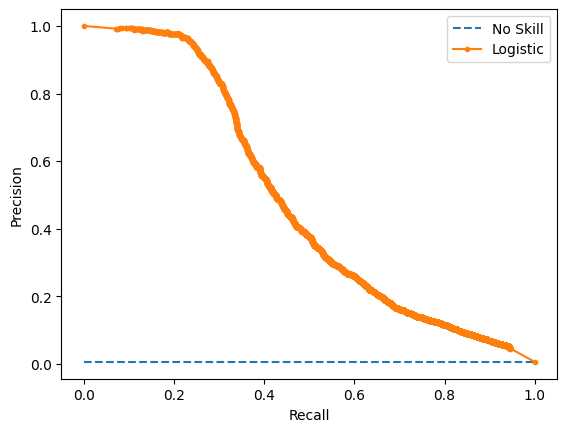

In [71]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from matplotlib import pyplot

y_score = best_random.predict_proba(X_test)[:, 1]
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

# predict class values
yhat = best_random.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_score)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)

# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [72]:
from sklearn.metrics import confusion_matrix

y_score = best_random.predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, y_score)

In [73]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_score, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    print()
    print('Precision score: ', format(precision_score(y_test, y_pred_adj)))
    print('Recall score: ', format(recall_score(y_test, y_pred_adj)))

    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.0, 1.01]);
    plt.xlim([0.0, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

     pred_neg  pred_pos
neg    287178       165
pos      1126       544

Precision score:  0.767277856135402
Recall score:  0.325748502994012


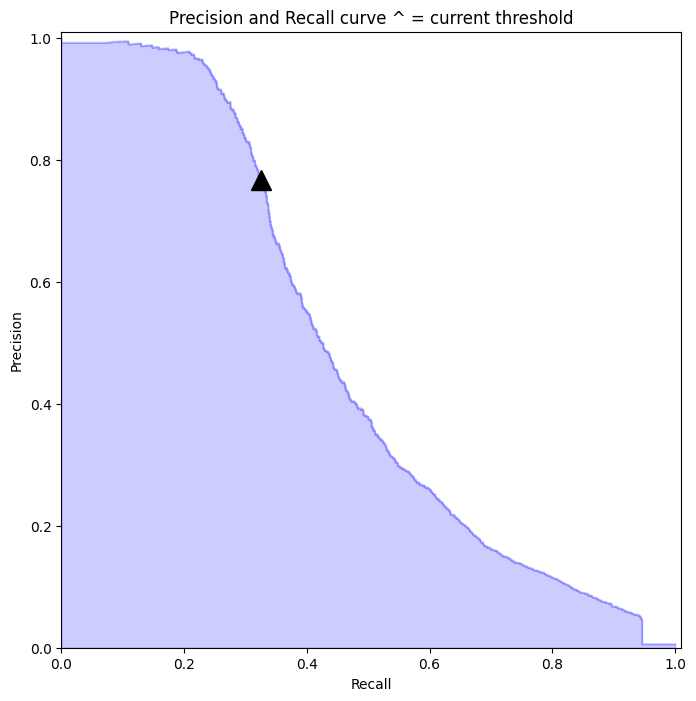

In [74]:
precision_recall_threshold(p, r, thresholds, 0.5)

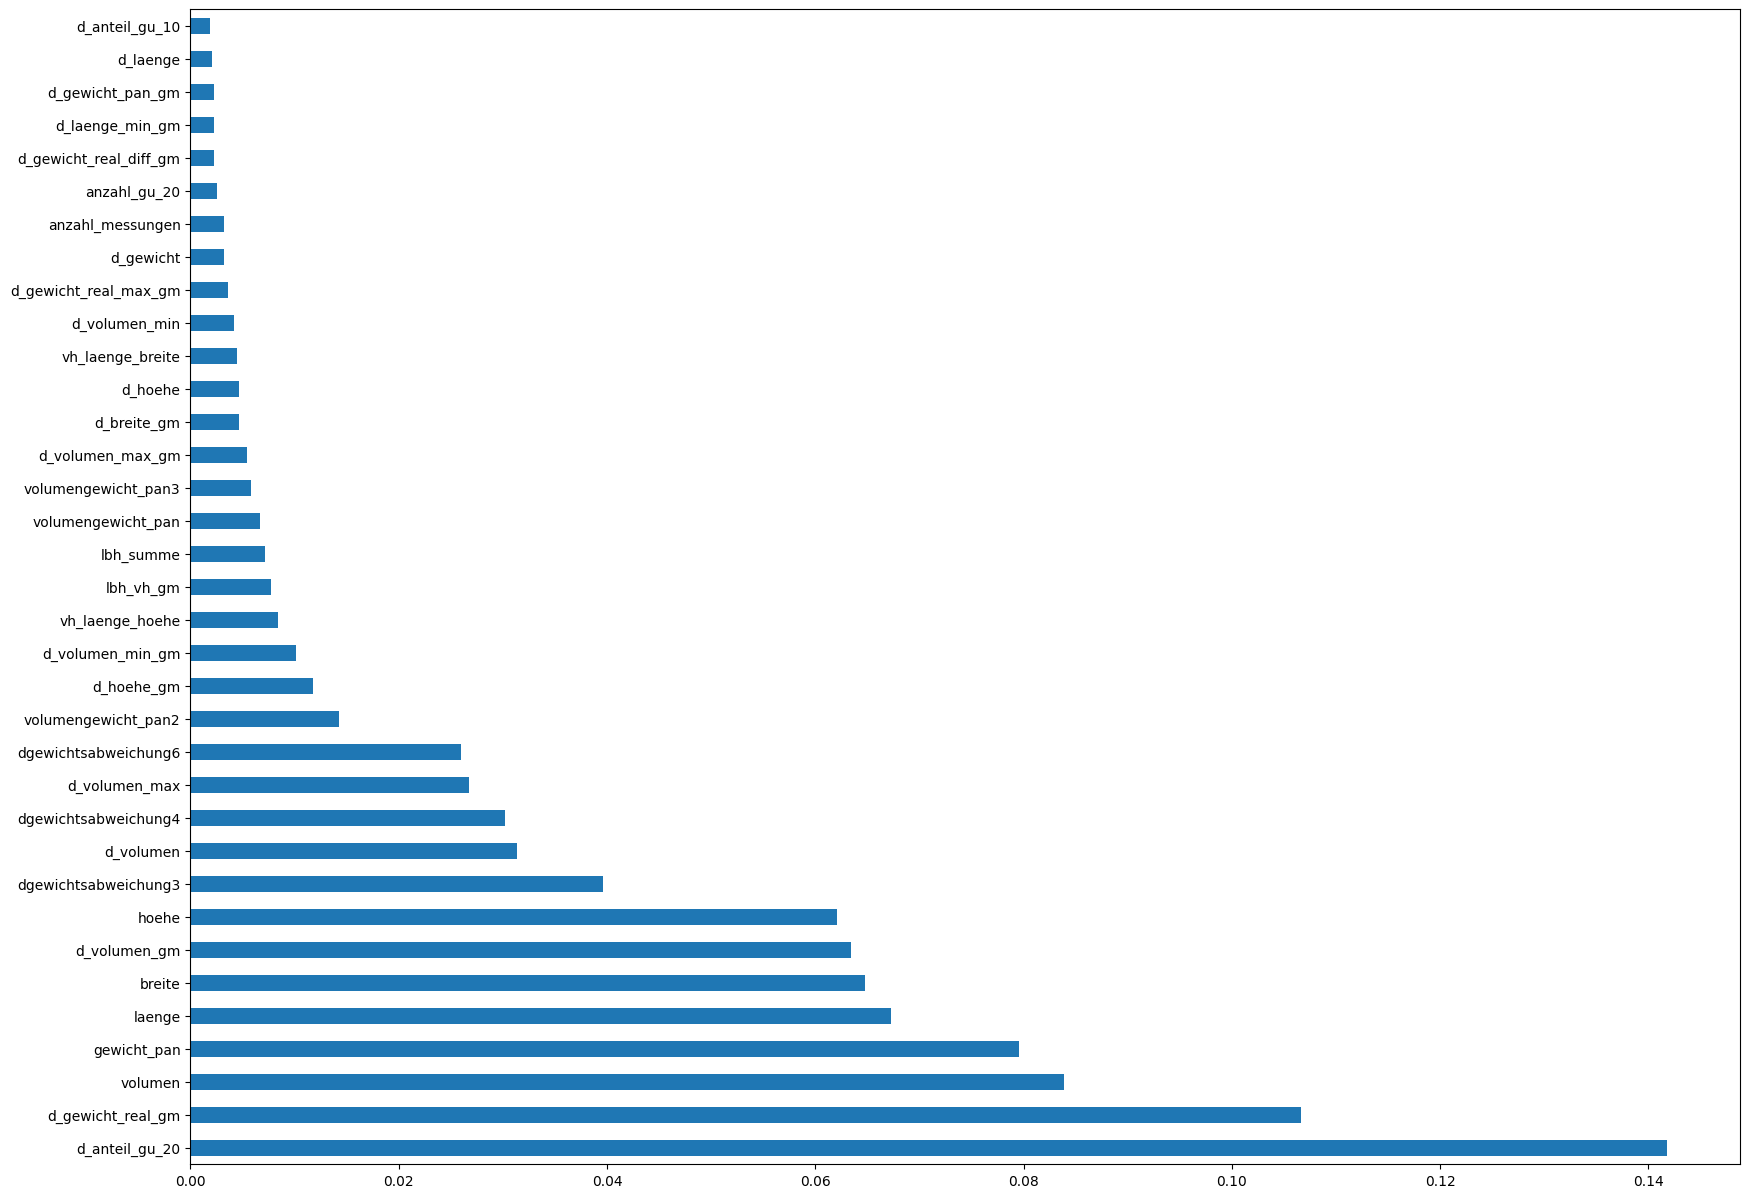

In [75]:
feat_importances = pd.Series(best_random.feature_importances_, index=X_train.columns.values)
feat_importances.nlargest(35).plot(kind='barh', figsize=(10, 15))

plt.show()

In [76]:
# Time taken to Make new predictions with base model
import time
start_time = time.time()
Erg2 = base_model.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))



--- 0.606684684753418 seconds ---


In [77]:
# Time taken to Make new predictions with tuned model
import time
start_time = time.time()
Erg2 = best_random.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))



--- 0.5797405242919922 seconds ---


In [78]:
Dateiname = 'GS_RF_Klassifikation_HER_GU_20_int.pkl'
    
print(Dateiname)

Speicherort = '/home/jovyan/shared-data/models_herkules/'+ Dateiname


import pickle

with open(Speicherort, 'wb') as f:
    pickle.dump(best_random, f)

GS_RF_Klassifikation_HER_GU_20_int.pkl


In [79]:
Speicherort = '/home/jovyan/shared-data/models_herkules/'+ Dateiname                                                                                                                                                                                                   
with open(Speicherort, 'rb') as f:
    RF_Doppleridentifizierung = pickle.load(f)

Erg3 = RF_Doppleridentifizierung.predict(X_test)
Erg3

array([0, 0, 0, ..., 0, 0, 0])

In [82]:
Dateiname = 'GS_RF_Klassifikation_HER_GU_20_int_base.pkl'
    
print(Dateiname)

Speicherort = '/home/jovyan/shared-data/models_herkules/'+ Dateiname


import pickle

with open(Speicherort, 'wb') as f:
    pickle.dump(base_model, f)

GS_RF_Klassifikation_HER_GU_20_int_base.pkl


In [83]:

Speicherort = '/home/jovyan/shared-data/models_herkules/'+ Dateiname                                                                                                                                                                                                   
with open(Speicherort, 'rb') as f:
    RF_Doppleridentifizierung = pickle.load(f)

Erg3 = RF_Doppleridentifizierung.predict(X_test)
Erg3

array([0, 0, 0, ..., 0, 0, 0])

# Random Forest Model to classify the parcels with weight greater than 10kg 

In [84]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(HK_Trainset_features, 
                                                    HK_Trainset_targetvar_GU_10, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 674363 samples.
Testing set has 289013 samples.


In [85]:
#Random forest model with default parameters
import time
start_time = time.time()

base_model = RandomForestClassifier(random_state = 33, n_jobs = 44)
base_model.fit(X_train,y_train)
base_f1_score = evaluate(base_model, X_test,y_test)

print("--- %s seconds ---" % (time.time() - start_time))

#Tuned Random Forest Model
start_time = time.time()

best_random = RandomForestClassifier(n_estimators=100, min_samples_split = 5, min_samples_leaf = 3, max_features = 45, max_depth = 30, criterion = 'entropy', bootstrap = False,  random_state = 33, n_jobs = 44)
best_random.fit(X_train,y_train)
random_f1_score = evaluate(best_random, X_test,y_test)

print("--- %s seconds ---" % (time.time() - start_time))
print('Improvement of {:0.2f}%.'.format( 100 * (random_f1_score - base_f1_score) / base_f1_score))

Accuracy score:  0.9673578697152031
Precision score:  0.6472032037204496
Recall score:  0.42772987279091607
F1 score:  0.5150611699393441



--- 15.774719953536987 seconds ---
Accuracy score:  0.9690152346088238
Precision score:  0.6999709976798144
Recall score:  0.4121062067787928
F1 score:  0.5187812348863453



--- 52.49587416648865 seconds ---
Improvement of 0.72%.


Average precision-recall score: 0.62
Logistic: f1=0.519 auc=0.620


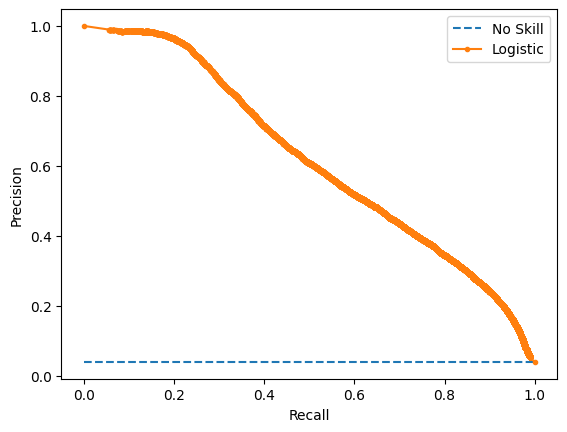

In [86]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from matplotlib import pyplot

y_score = best_random.predict_proba(X_test)[:, 1]
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

# predict class values
yhat = best_random.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_score)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)

# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [87]:
from sklearn.metrics import confusion_matrix

y_score = best_random.predict_proba(X_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, y_score)

In [88]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_score, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    print()
    print('Precision score: ', format(precision_score(y_test, y_pred_adj)))
    print('Recall score: ', format(recall_score(y_test, y_pred_adj)))

    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.0, 1.01]);
    plt.xlim([0.0, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

     pred_neg  pred_pos
neg    275231      2069
pos      6886      4827

Precision score:  0.6999709976798144
Recall score:  0.4121062067787928


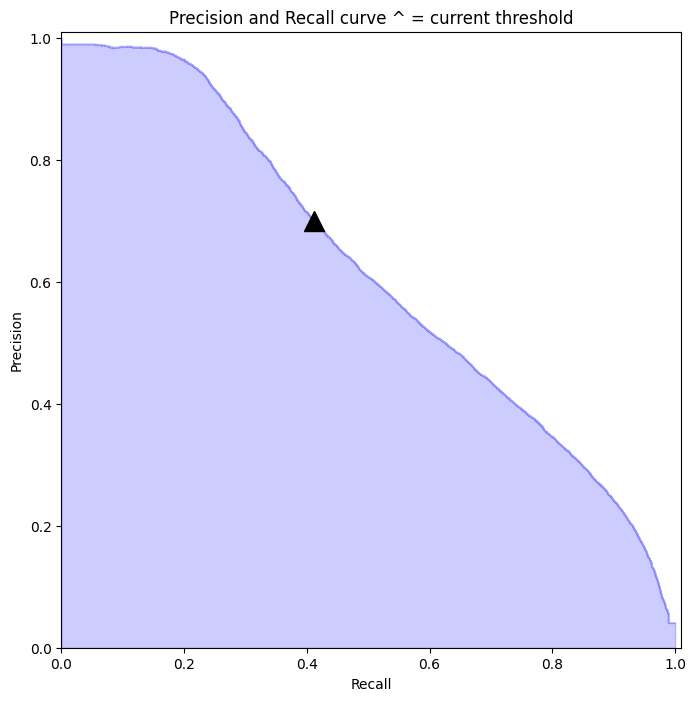

In [89]:
precision_recall_threshold(p, r, thresholds, 0.5)

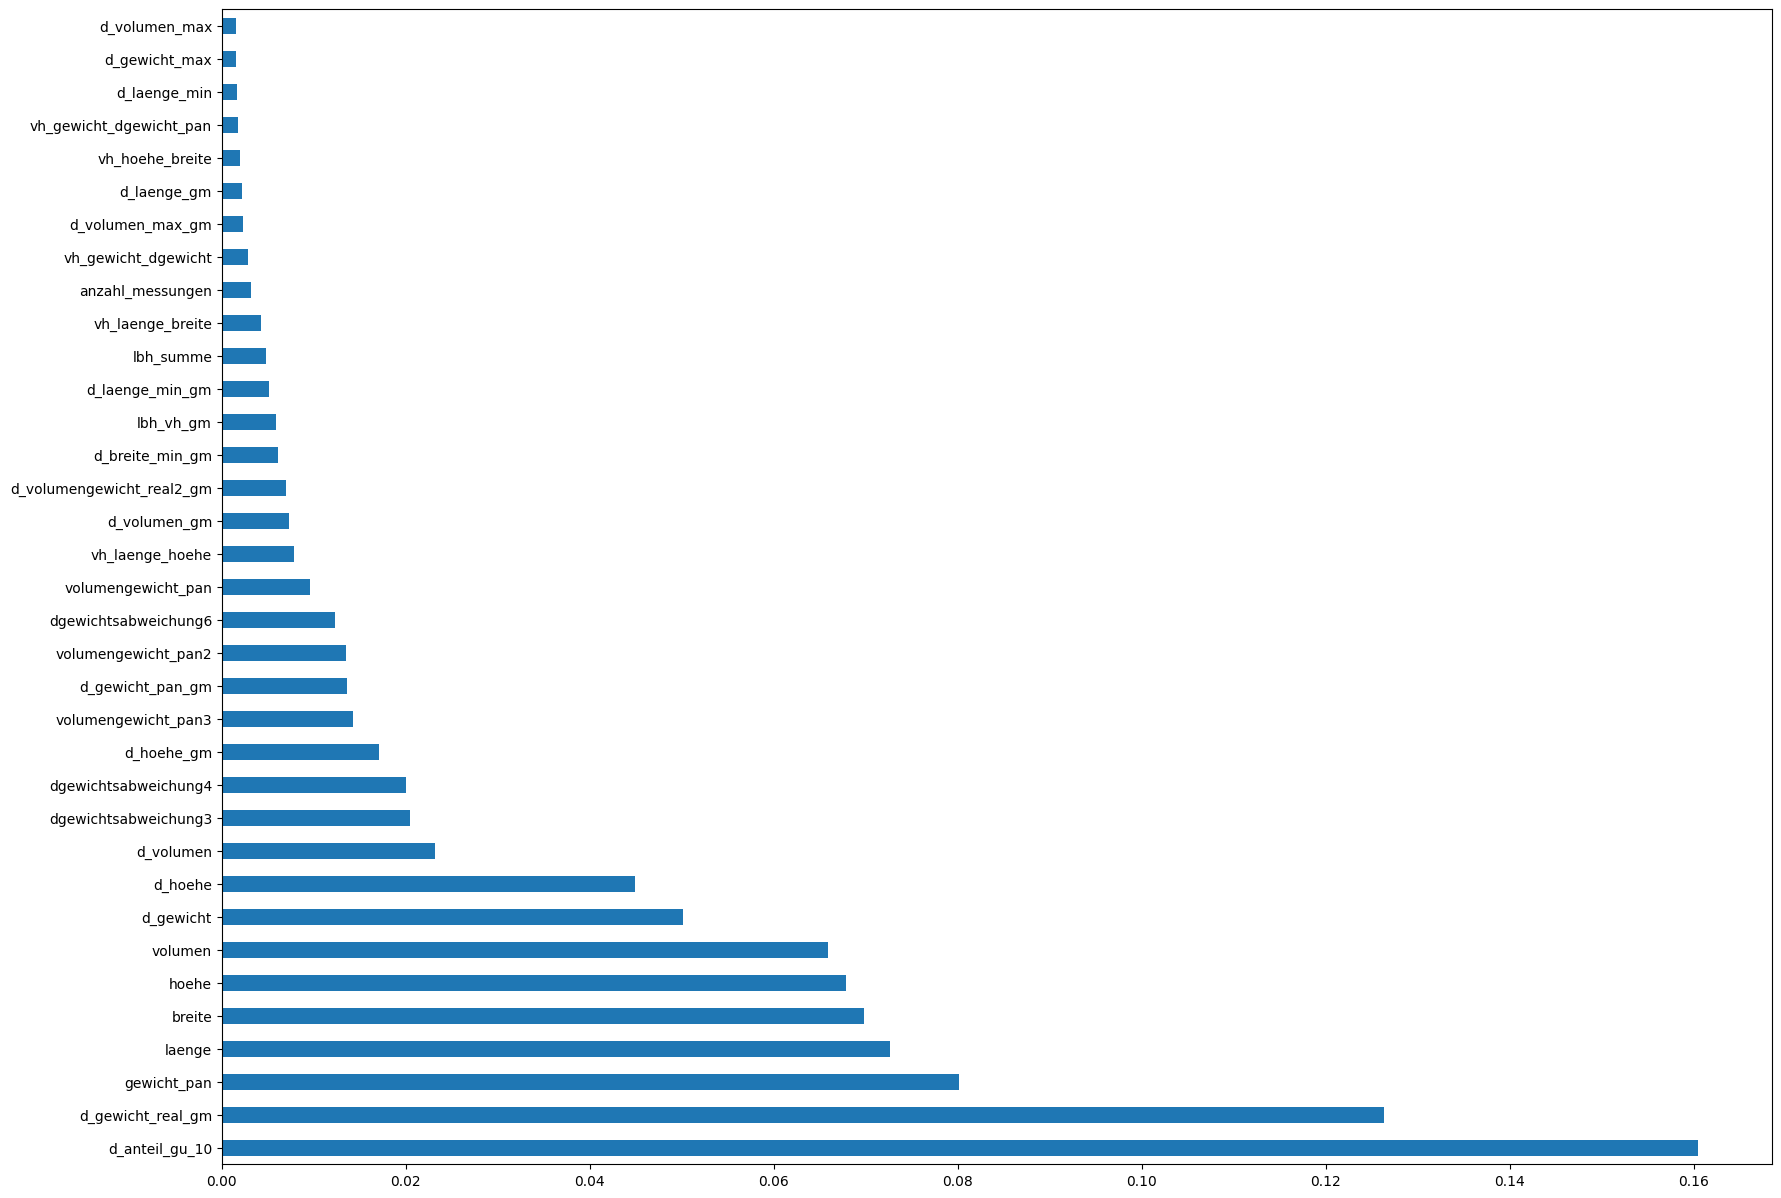

In [90]:
feat_importances = pd.Series(best_random.feature_importances_, index=X_train.columns.values)
feat_importances.nlargest(35).plot(kind='barh', figsize=(20, 15))

plt.show()

In [91]:
# Time taken to Make new predictions with base model
import time
start_time = time.time()
Erg2 = base_model.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))



--- 0.7707676887512207 seconds ---


In [92]:
# Time taken to Make new predictions with tuned model
import time
start_time = time.time()
Erg2 = best_random.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))



--- 0.7351217269897461 seconds ---


In [94]:
Dateiname = 'GS_RF_Klassifikation_HER_GU_10_int.pkl'
    
print(Dateiname)

Speicherort = '/home/jovyan/shared-data/models_herkules/'+ Dateiname


import pickle

with open(Speicherort, 'wb') as f:
    pickle.dump(best_random, f)

GS_RF_Klassifikation_HER_GU_10_int.pkl


In [95]:
Speicherort = '/home/jovyan/shared-data/models_herkules/'+ Dateiname                                                                                                                                                                                                   
with open(Speicherort, 'rb') as f:
    RF_Doppleridentifizierung = pickle.load(f)

Erg3 = RF_Doppleridentifizierung.predict(X_test)
Erg3

array([0, 0, 0, ..., 0, 0, 0])

# Random Forest model to predict the weight of the parcel 

In [93]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(HK_Trainset_features, 
                                                    HK_Trainset_targetvar_GR, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 674363 samples.
Testing set has 289013 samples.


In [94]:
#import models and metrics from sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

#Function "evaluate" to get the evaluation metrics for prediction model
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    r2_score_erg = r2_score(test_labels, predictions)
    print('R2 score: ', format(r2_score_erg))
    print('mean squared error: ', format(mean_squared_error(test_labels, predictions)))
    print('mean absolute error: ', format(mean_absolute_error(test_labels, predictions)))
    print('\n\n')
    return r2_score_erg


import time
start_time = time.time()

base_model_reg = RandomForestRegressor(random_state = 33, n_jobs = 44)
base_model_reg.fit(X_train,y_train)
base_r2_score = evaluate(base_model_reg, X_test,y_test)

print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()

best_random_reg = RandomForestRegressor(n_estimators=40, min_samples_split = 3, min_samples_leaf = 4, max_features = 40, max_depth = 25, bootstrap = True,  random_state = 33, n_jobs = 44)
best_random_reg.fit(X_train,y_train)
random_r2_score = evaluate(best_random_reg, X_test,y_test)

print("--- %s seconds ---" % (time.time() - start_time))


print('Improvement of {:0.2f}%.'.format( 100 * (random_r2_score - base_r2_score) / base_r2_score))

R2 score:  0.6631612170253395
mean squared error:  4.137102509723789
mean absolute error:  1.020195779143224



--- 118.63091468811035 seconds ---
R2 score:  0.6873074405415702
mean squared error:  3.840535110248103
mean absolute error:  0.9627781880687243



--- 14.152851343154907 seconds ---
Improvement of 3.64%.


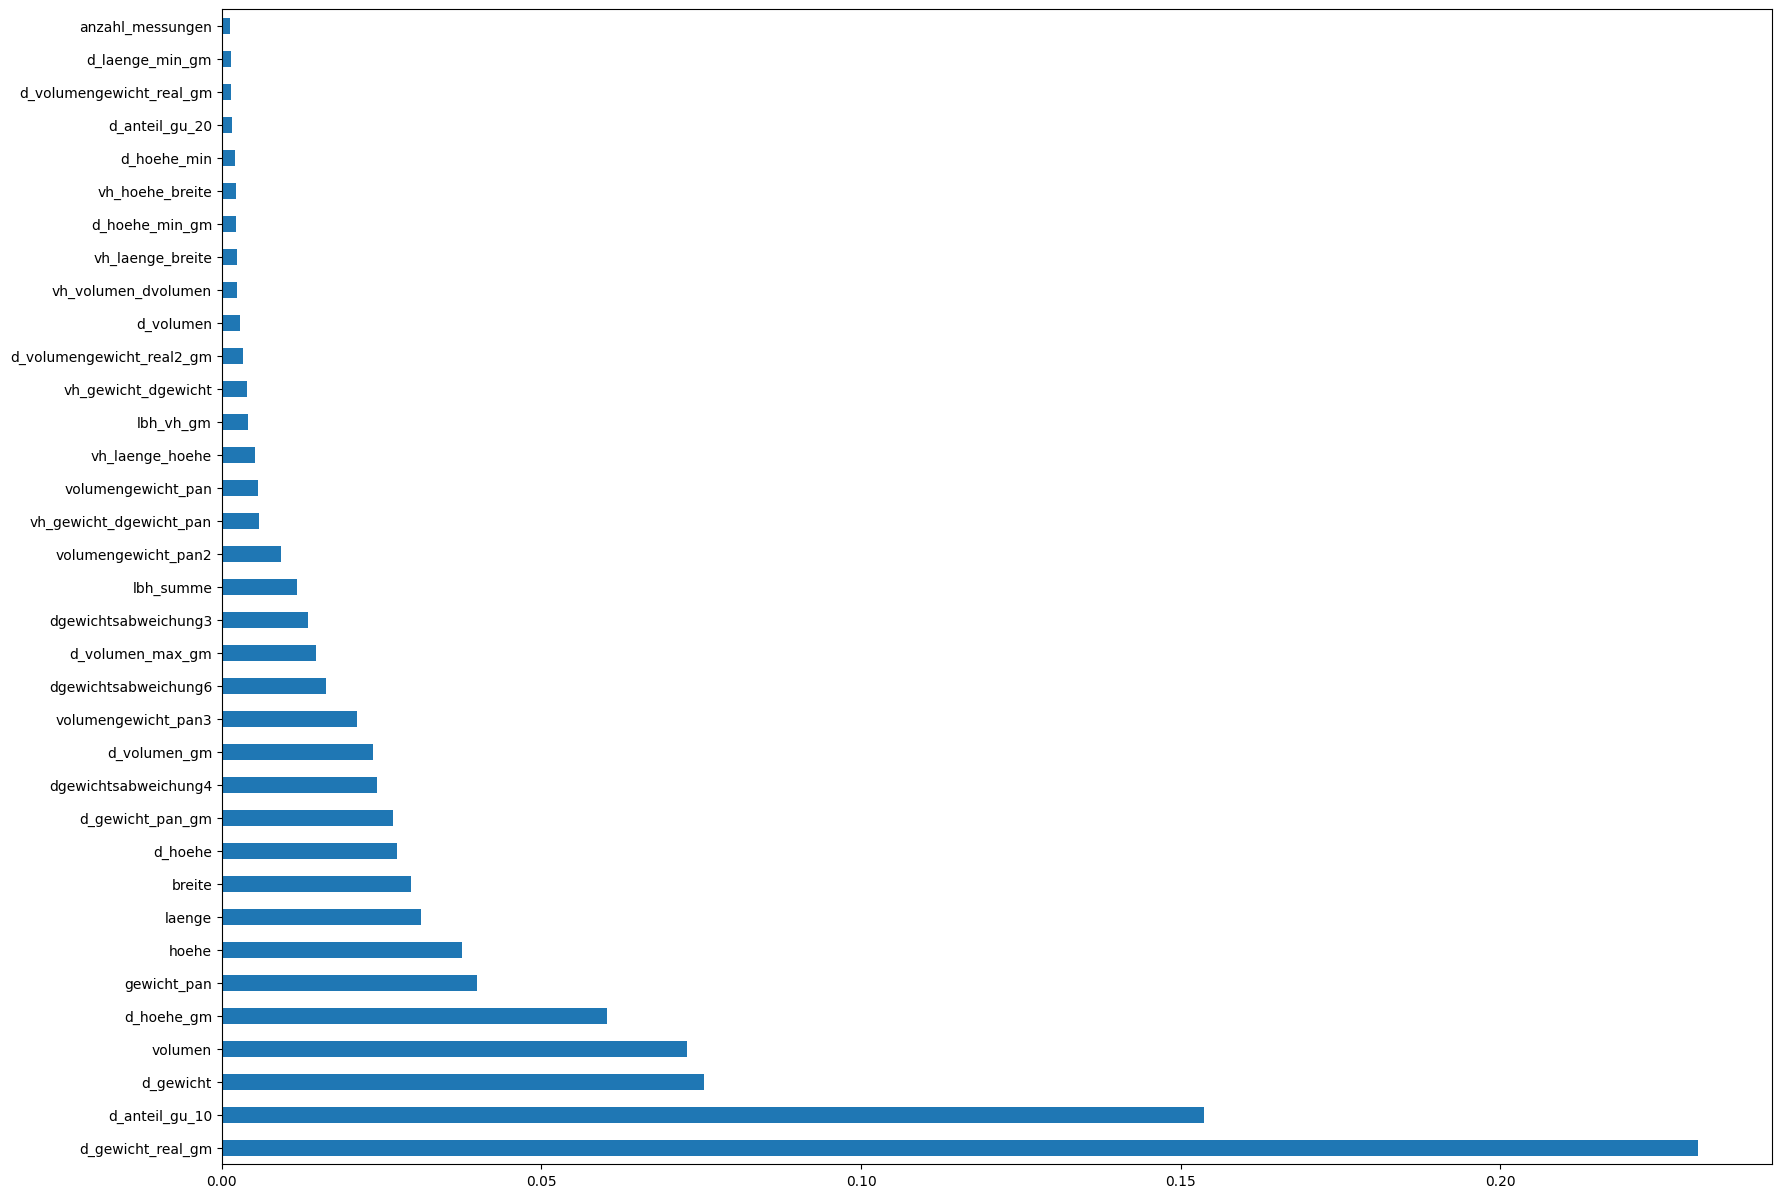

In [95]:
feat_importances = pd.Series(best_random_reg.feature_importances_, index=X_train.columns.values)
feat_importances.nlargest(35).plot(kind='barh', figsize=(20, 15))

plt.show()

[0.23091259 0.15359224 0.0754481  0.07273197 0.06023403 0.03984231
 0.03758747 0.03114575 0.02960718 0.02733807 0.02670139 0.02422447
 0.02365334 0.02113791 0.0163516 ]
['d_gewicht_real_gm' 'd_anteil_gu_10' 'd_gewicht' 'volumen' 'd_hoehe_gm'
 'gewicht_pan' 'hoehe' 'laenge' 'breite' 'd_hoehe' 'd_gewicht_pan_gm'
 'dgewichtsabweichung4' 'd_volumen_gm' 'volumengewicht_pan3'
 'dgewichtsabweichung6']


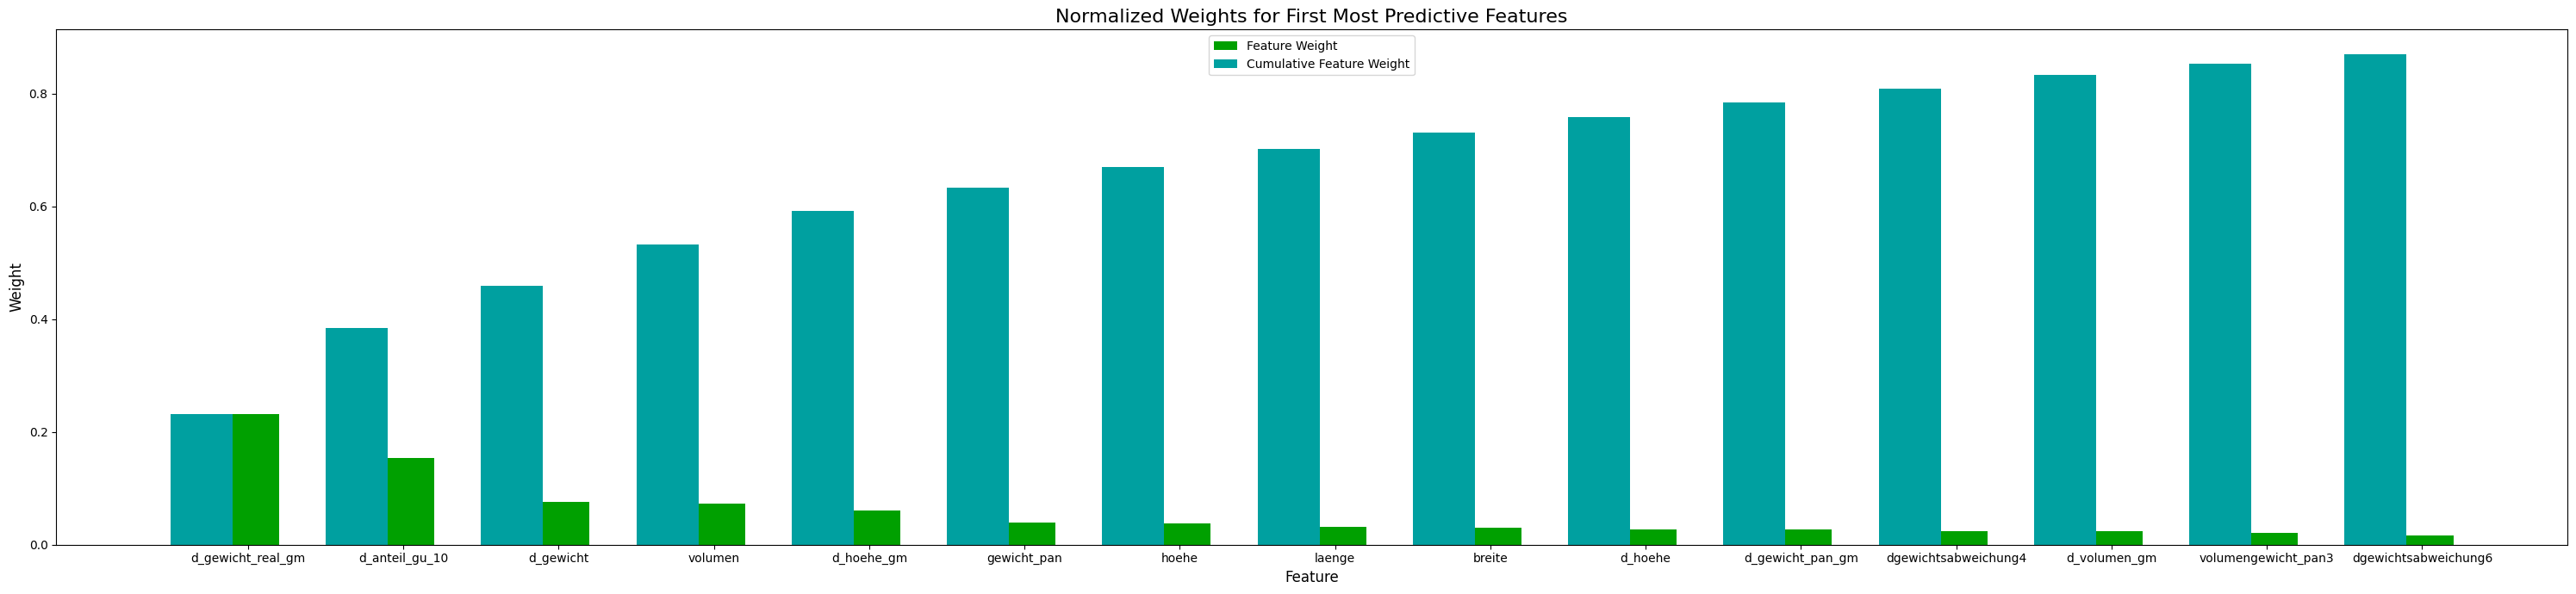

In [96]:
# TODO: Extract the feature importances using .feature_importances_ 
importances = best_random_reg.feature_importances_

def feature_plot(importances, X_train, y_train, Anzahl_features):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:Anzahl_features]]
    values = importances[indices][:Anzahl_features]
    
    print(values)
    print(columns)

    # Creat the plot
    fig = plt.figure(figsize = (30,7))
    plt.title("Normalized Weights for First Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(Anzahl_features), values, width = 0.4, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(Anzahl_features) - 0.3, np.cumsum(values), width = 0.4, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(Anzahl_features), columns)
    #plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  


# Plot
feature_plot(importances, X_train, y_train,15)

In [97]:
# Make new predictions
import time
start_time = time.time()
Erg2 = best_random_reg.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))




--- 0.769075870513916 seconds ---


In [98]:
# Make new predictions
import time
start_time = time.time()
Erg2 = base_model_reg.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))




--- 1.9369282722473145 seconds ---


In [99]:

Dateiname = 'GS_RF_Prognose_Gewicht_Herkules_int.pkl'

print(Dateiname)
Speicherort = '/home/jovyan/shared-data/models_herkules/'+ Dateiname        


import pickle

with open(Speicherort, 'wb') as f:
    pickle.dump(best_random_reg, f)

GS_RF_Prognose_Gewicht_Herkules_int.pkl


In [100]:
Speicherort = '/home/jovyan/shared-data/models_herkules/'+ Dateiname                                                                                                                                                                                                    

with open(Speicherort, 'rb') as f:
    RF_Weight_prediction = pickle.load(f)


Erg3 = RF_Weight_prediction.predict(X_test)
Erg3

array([1.90614159, 1.66216114, 0.51677465, ..., 0.60340766, 2.07923152,
       3.39498272])

# SVM model for classifying the parcels greater than 20kg

In [101]:
HK_Trainset_int_sample_svm.head()

,gewicht_real,volumen,laenge,breite,hoehe,anzahl_messungen,gewicht_pan,flag_gewicht_20,flag_gewicht_10,anzahl_gm,d_anzahl_gm,d_hoehe_gm,d_laenge_gm,d_breite_gm,d_gewicht_real_gm,d_gewicht_pan_gm,d_volumen_gm,d_hoehe_min_gm,d_hoehe_max_gm,d_laenge_min_gm,d_laenge_max_gm,d_breite_min_gm,d_breite_max_gm,d_gewicht_real_min_gm,d_gewicht_real_max_gm,d_gewicht_pan_min_gm,d_gewicht_pan_max_gm,d_volumen_min_gm,d_volumen_max_gm,d_volumengewicht_real_gm,d_volumengewicht_pan_gm,d_lbh_summe_gm,d_volumengewicht_real2_gm,d_volumengewicht_pan2_gm,d_gewichtsabweichung_gm,anzahl_gu_20,anzahl_gu_10,d_anteil_gu_20,d_anteil_gu_10,d_laenge_diff_gm,d_breite_diff_gm,d_hoehe_diff_gm,d_volumen_diff_gm,d_gewicht_pan_diff_gm,d_gewicht_real_diff_gm,d_volumengewicht_diff_gm,anzahl,d_anzahl,d_hoehe,d_laenge,d_breite,d_gewicht,d_volumen,d_hoehe_min,d_hoehe_max,d_laenge_min,d_laenge_max,d_breite_min,d_breite_max,d_gewicht_min,d_gewicht_max,d_volumen_min,d_volumen_max,d_lbh_summe,d_volumengewicht_pan,d_volumengewicht_pan2,d_volumengewicht_pan3,vh_laenge_hoehe,vh_laenge_breite,vh_hoehe_breite,vh_laenge_dlaenge,vh_breite_dbreite,vh_hoehe_dhoehe,vh_volumen_dvolumen,vh_gewicht_dgewicht,vh_gewicht_dgewicht_pan,dgewichtsabweichung3,dgewichtsabweichung4,dgewichtsabweichung5,dgewichtsabweichung6,lbh_summe,lbh_vh_gm,volumengewicht_pan,volumengewicht_pan2,volumengewicht_pan3,anzahl_land_flag_ratio,volumen_grp_V20,volumen_grp_V30,volumen_grp_V40,volumen_grp_V50,volumen_grp_V70,volumen_grp_V90,volumen_grp_V99,parcel_shape_None,parcel_shape_bag,parcel_shape_cuboid,parcel_shape_envelope,country_code_AT,country_code_AU,country_code_BE,country_code_BG,country_code_BR,country_code_BY,country_code_CA,country_code_CH,country_code_CN,country_code_CY,country_code_CZ,country_code_DK,country_code_EE,country_code_ES,country_code_FI,country_code_FR,country_code_GB,country_code_GR,country_code_HR,country_code_HU,country_code_IE,country_code_IN,country_code_IS,country_code_IT,country_code_JP,country_code_KR,country_code_KZ,country_code_LI,country_code_LT,country_code_LU,country_code_LV,country_code_MT,country_code_NL,country_code_NO,country_code_NZ,country_code_PL,country_code_PT,country_code_RO,country_code_RS,country_code_RU,country_code_SE,country_code_SI,country_code_SK,country_code_TH,country_code_TR,country_code_TW,country_code_UA,country_code_US,country_code_XX
673837,3.50,34.0,447.0,298.0,255.0,1,0,0,0,13933,64,228.0,465.0,340.0,4.0,4.0,34.0,38.0,428.0,263.666667,1556.0,140.0,785.0,0.15,30.90,0.002,9.987,30.0,39.666667,12.0,12.0,10.0,3.0,3.0,0.0,62,545,0.00,4.00,1292.333333,645.0,390.0,9.666667,9.985,30.75,0.0,50851.0,139.0,224.0,470.0,343.0,4.0,34.0,52.0,574.0,218.5,1407.0,143.0,750.0,0.002,33.1,30.0,39.666667,10.0,11.0,3.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,10.0,0.0,10.0,100.0,0.0,12.0,0.0,0.0000,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
123872,1.20,6.0,297.0,206.0,98.0,1,0,0,0,40479,197,128.0,329.0,243.0,2.0,2.0,10.0,0.0,350.0,0.000000,1210.0,0.0,643.0,0.05,28.15,0.113,9.980,0.0,19.500000,20.0,20.0,7.0,4.0,4.0,0.0,7,117,0.00,0.00,1210.000000,643.0,350.0,19.500000,9.867,28.10,0.0,24629.0,67.0,124.0,325.0,239.0,2.0,10.0,0.0,300.0,0.0,1203.0,0.0,658.0,0.001,30.0,0.0,19.500000,7.0,22.0,4.0,0.0,3.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,10.0,0.0,6.0,86.0,0.0,33.0,0.0,0.0100,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
321839,0.25,3.0,231.0,122.0,120.0,

In [102]:
# Split the data into features and target label
drop_col = ['gewicht_real',  'flag_gewicht_20', 'flag_gewicht_10']

HK_Trainset_targetvar_GR = HK_Trainset_int_sample_svm['gewicht_real']
HK_Trainset_targetvar_GU_20 = HK_Trainset_int_sample_svm['flag_gewicht_20']
HK_Trainset_targetvar_GU_10= HK_Trainset_int_sample_svm['flag_gewicht_10']


HK_Trainset_features = HK_Trainset_int_sample_svm.drop(drop_col, axis=1)

In [103]:
# scaling the data
from sklearn.preprocessing import StandardScaler

columns_scaled =HK_Trainset_features.columns
scaler = StandardScaler()
HK_Trainset_features_scaled = pd.DataFrame(data = HK_Trainset_features)
HK_Trainset_features_scaled[columns_scaled]=scaler.fit_transform(HK_Trainset_features[columns_scaled])

# Show an example of a record with scaling applied
display(HK_Trainset_features_scaled.head(n = 5))

,volumen,laenge,breite,hoehe,anzahl_messungen,gewicht_pan,anzahl_gm,d_anzahl_gm,d_hoehe_gm,d_laenge_gm,d_breite_gm,d_gewicht_real_gm,d_gewicht_pan_gm,d_volumen_gm,d_hoehe_min_gm,d_hoehe_max_gm,d_laenge_min_gm,d_laenge_max_gm,d_breite_min_gm,d_breite_max_gm,d_gewicht_real_min_gm,d_gewicht_real_max_gm,d_gewicht_pan_min_gm,d_gewicht_pan_max_gm,d_volumen_min_gm,d_volumen_max_gm,d_volumengewicht_real_gm,d_volumengewicht_pan_gm,d_lbh_summe_gm,d_volumengewicht_real2_gm,d_volumengewicht_pan2_gm,d_gewichtsabweichung_gm,anzahl_gu_20,anzahl_gu_10,d_anteil_gu_20,d_anteil_gu_10,d_laenge_diff_gm,d_breite_diff_gm,d_hoehe_diff_gm,d_volumen_diff_gm,d_gewicht_pan_diff_gm,d_gewicht_real_diff_gm,d_volumengewicht_diff_gm,anzahl,d_anzahl,d_hoehe,d_laenge,d_breite,d_gewicht,d_volumen,d_hoehe_min,d_hoehe_max,d_laenge_min,d_laenge_max,d_breite_min,d_breite_max,d_gewicht_min,d_gewicht_max,d_volumen_min,d_volumen_max,d_lbh_summe,d_volumengewicht_pan,d_volumengewicht_pan2,d_volumengewicht_pan3,vh_laenge_hoehe,vh_laenge_breite,vh_hoehe_breite,vh_laenge_dlaenge,vh_breite_dbreite,vh_hoehe_dhoehe,vh_volumen_dvolumen,vh_gewicht_dgewicht,vh_gewicht_dgewicht_pan,dgewichtsabweichung3,dgewichtsabweichung4,dgewichtsabweichung5,dgewichtsabweichung6,lbh_summe,lbh_vh_gm,volumengewicht_pan,volumengewicht_pan2,volumengewicht_pan3,anzahl_land_flag_ratio,volumen_grp_V20,volumen_grp_V30,volumen_grp_V40,volumen_grp_V50,volumen_grp_V70,volumen_grp_V90,volumen_grp_V99,parcel_shape_None,parcel_shape_bag,parcel_shape_cuboid,parcel_shape_envelope,country_code_AT,country_code_AU,country_code_BE,country_code_BG,country_code_BR,country_code_BY,country_code_CA,country_code_CH,country_code_CN,country_code_CY,country_code_CZ,country_code_DK,country_code_EE,country_code_ES,country_code_FI,country_code_FR,country_code_GB,country_code_GR,country_code_HR,country_code_HU,country_code_IE,country_code_IN,country_code_IS,country_code_IT,country_code_JP,country_code_KR,country_code_KZ,country_code_LI,country_code_LT,country_code_LU,country_code_LV,country_code_MT,country_code_NL,country_code_NO,country_code_NZ,country_code_PL,country_code_PT,country_code_RO,country_code_RS,country_code_RU,country_code_SE,country_code_SI,country_code_SK,country_code_TH,country_code_TR,country_code_TW,country_code_UA,country_code_US,country_code_XX
673837,0.619146,0.638572,0.397080,1.178434,-0.183177,-0.083525,-0.779164,-0.834421,1.079136,1.108835,1.158324,0.534903,0.544692,0.653207,0.410103,0.008853,1.327228,2.285219,1.069732,0.197777,0.030678,0.717806,-0.205336,-0.149165,0.920637,0.092333,-0.857254,-0.345785,1.019022,-0.854253,-0.896663,-0.03922,0.550471,0.692040,-0.228462,0.011585,0.716055,-0.360257,-0.206814,-0.343673,-0.130119,0.708904,0.025232,-0.677563,-0.677378,1.082445,1.095177,1.208377,0.574823,0.642879,0.771325,0.896116,0.941287,-0.600227,1.001822,-0.305044,-0.212219,-0.182750,0.921082,0.069532,1.008768,-0.946815,-0.815453,-0.411994,-0.153518,0.964663,0.766864,-0.113264,-0.052457,-0.020525,-0.063444,-0.097296,-0.369485,-0.548661,-0.548988,0.05815,-0.548648,0.851574,-0.115838,-0.441164,-0.618547,-0.440625,-0.430585,-1.568335,-0.350556,3.896530,-0.183666,-0.209541,-0.137262,-0.158892,0.252097,-0.10343,-0.223366,-0.040645,1.482485,-0.052994,-0.26544,-0.050164,-0.029849,-0.024922,-0.04399,-0.111521,-0.074803,-0.031907,-0.07317,-0.060498,-0.078363,-0.158948,-0.038655,-0.509716,-0.125691,-0.069182,-0.276023,-0.034594,-0.090636,-0.049434,-0.032006,-0.149821,-0.084439,-0.052132,-0.045461,-0.020329,-0.083457,-0.056594,-0.063921,-0.026014,-0.147633,-0.079165,-0.028481,-0.169971,-0.079553,-0.110622,-0.0357,-0.06287,-0.076534,-0.064579,-0.055398,-0.032414,-0.124567,-0.050562,-0.110062,-0.251027,-0.101587
123872,-0.517705,-0.463007,-0.589799,-0.583739,-0.183177,-0.083525,-0.492869,-0.461572,-0.305206,-0.329359,-0.264574,-0.231269,-0.200939,-0.371261,-0.524357,-0.913410,-0.611460,-0.188821,-0.605854,-0.786371,-0.247650,0.203304,-0.122998,-0.149621,-0.530797,-0.276752,1.084371,0.399331,-0.261238,-0.288808,-0.330684

In [104]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(HK_Trainset_features_scaled, 
                                                    HK_Trainset_targetvar_GU_20, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 667619 samples.
Testing set has 286123 samples.


In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score

from sklearn.metrics import roc_curve, auc, roc_auc_score

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    f1_score_erg = f1_score(test_labels, predictions)
    print('Accuracy score: ', format(accuracy_score(test_labels, predictions)))
    print('Precision score: ', format(precision_score(test_labels, predictions)))
    print('Recall score: ', format(recall_score(test_labels, predictions)))
    print('F1 score: ', format(f1_score(test_labels, predictions)))
    #print('Beta score: ', format(fbeta_score(test_labels, predictions, beta=1))
    print('\n\n')
    return f1_score_erg

#Using SVM model for classifying the parcels greater than 20kg with deault parameters
import time
start_time = time.time()

# import SVC classifier
from sklearn.svm import SVC

# instantiate classifier 
svc=SVC(probability=True) 

# fit classifier to training set
svc.fit(X_train,y_train)

# make predictions on test set
svc_score =evaluate(svc,X_test,y_test)

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred =svc.predict(X_test)

# The confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

print(cnf_matrix)


In [ ]:
Dateiname = 'GS_SVM_Klassifikation_HER_GU_20_int.pkl'
    
print(Dateiname)

Speicherort = '/home/jovyan/shared-data/models_herkules/'+ Dateiname


import pickle

with open(Speicherort, 'wb') as f:
    pickle.dump(svc, f)

In [ ]:
Speicherort = '/home/jovyan/shared-data/models_herkules/'+ Dateiname                                                                                                                                                                                                   
with open(Speicherort, 'rb') as f:
    RF_Doppleridentifizierung = pickle.load(f)

Erg3 = RF_Doppleridentifizierung.predict(X_test)
Erg3

# SVM Regressor model for predicting the weight of the parcel

In [ ]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(HK_Trainset_features_scaled, 
                                                    HK_Trainset_targetvar_GR, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

In [ ]:

#Regression:

from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    r2_score_erg = r2_score(test_labels, predictions)
    print('R2 score: ', format(r2_score_erg))
    print('mean squared error: ', format(mean_squared_error(test_labels, predictions)))
    print('mean absolute error: ', format(mean_absolute_error(test_labels, predictions)))
    print('\n\n')
    return r2_score_erg


import time
start_time = time.time()

base_model = SVR()
base_model.fit(X_train,y_train)
base_score = evaluate(base_model, X_test,y_test)

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
Dateiname = 'GS_SVM_Regression_Herkules_int.pkl'
    
print(Dateiname)

Speicherort = '/home/jovyan/shared-data/models_herkules/'+ Dateiname


import pickle

with open(Speicherort, 'wb') as f:
    pickle.dump(base_model, f)

In [ ]:
Speicherort = '/home/jovyan/shared-data/models_herkules/'+ Dateiname                                                                                                                                                                                                   
with open(Speicherort, 'rb') as f:
    RF_Doppleridentifizierung = pickle.load(f)

Erg3 = RF_Doppleridentifizierung.predict(X_test)
Erg3

In [ ]:
# Overview of the models

#'GS_RF_Klassifikation_HER_GU_20_int.pkl' for classifying the parcels greater than 20kg using Random Forest Classifier
#'GS_RF_Klassifikation_HER_GU_10_int.pkl' for classifying the parcels greater than 10 kg using Random Forest Classifier
#'GS_RF_Prognose_Gewicht_Herkules_int.pkl' for predicting the weight of the parcels using Random Forest Regressor

#'GS_SVM_Klassifikation_HER_GU_20_int.pkl' for classifying the parcels greater than 20kg using SVM classifier 
#'GS_SVM_Regression_Herkules_int.pkl' for predicting the weight of the parcels using SVM Regressor



In [ ]:
# Initialize lists to store scores
Accuracy = []
Precision = []
Recall = []
F1_score = []
y_pred = model.predict(X_test)
Accuracy.append(accuracy_score(y_test, y_pred))
Precision.append(precision(y_test, y_pred))
Recall.append(recall_score(y_test, y_pred))
F1_scaore.append(f1_score(y_test, y_pred))


plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.plot(n_estimators, scores_n_estimators, marker='o')
plt.title('F1 Score vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('F1 Score')

# ENDE !!!!